In [32]:
# import torch
# import torch.nn as nn

# # 20 samples, 3 classes (logits for each sample)
# actions_pred = torch.randn(20, 3)  # Shape: (20, 3)

# # Corresponding labels (class indices)
# labels = torch.tensor([0, 1, 2, 1, 0, 2, 1, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0])  # Shape: (20,)


# # Define cross-entropy loss function
# criterion = nn.CrossEntropyLoss()
# print("actions_pred",actions_pred.shape)
# print("labels",labels.shape)
# # Compute loss
# loss = criterion(actions_pred, labels)

# print(f'Loss: {loss.item()}')


# input = torch.randn(3, 5, requires_grad=True)
# target = torch.empty(3, dtype=torch.long).random_(5)

# print("input",input.shape)
# print("target",target.shape)

In [33]:
import os; graphs_save_folder = "./NewGraphs/"; os.makedirs(graphs_save_folder, exist_ok=True)

In [34]:
# import numpy as np
# def convert_to_classes(action):
#     """Convert actions to classes."""
#     return np.vectorize(lambda x: 0 if x < 0.5 else 1 if x < 1.5 else 2)(action)

# Function to convert true actions
def convert_to_classes(action):
    if action == 0.25:
        return 0
    elif action == 0.5:
        return 1
    elif action == 0.75:
        return 2
    elif action == 0.1:
        return 1
    else:
        return 100

In [35]:
label_name="Training "

In [36]:
# Directory containing the log files (update this path as needed)
log_dir = './21-01-25 llama_train_logs'

log_dir = './opt_self_train_log'
log_dir = "eval_logs_llm.json"

In [37]:
import os
import json
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np



# Initialize lists to store the data
epoch_numbers = []
mean_losses = []
median_losses = []
mean_accuracies = []
mean_cpu_usage = []
mean_ram_usage = []
mean_gpu_usage = []
mean_vram_usage = []
mean_disk_read_speed = []
mean_disk_write_speed = []
returns_list = []

# Read all the custom_logs_epoch_train_*.json files
log_files = [f for f in os.listdir(log_dir) if f.startswith('custom_logs_epoch_train_') and f.endswith('.json')]

# Sort the log files based on the epoch number
log_files.sort(key=lambda x: int(x.split('_')[-1].split('.')[0]))

# Loop through each log file and extract relevant metrics
for log_file in log_files:
    epoch_number = int(log_file.split('_')[-1].split('.')[0])
    epoch_numbers.append(epoch_number)

    with open(os.path.join(log_dir, log_file), 'r') as file:
        data = json.load(file)
        
        losses = [step['train_loss'] for step in data['steps']]
        actions_preds = [step['actions_pred'] for step in data['steps']]
        actions = [step['labels'] for step in data['steps']]
        returns = [step['returns'] for step in data['steps']]
        
        # Calculate mean and median losses
        mean_loss = np.mean(losses)
        median_loss = np.median(losses)
        
        mean_losses.append(mean_loss)
        median_losses.append(median_loss)

        returns_list.append(returns)

        # Calculate accuracy
        print("-"*50)
        print("actions_preds",actions_preds)
        accuracies = []
        for preds, true_actions in zip(actions_preds, actions):
            preds_array = np.array(preds)
            print("preds_array",preds_array)
            true_actions_array = np.array(true_actions)
            preds_indices = preds_array.argmax(axis=1).flatten()
            print("preds_indices",preds_indices)
            print("true_actions_array",true_actions_array)
            
            accuracy = (preds_indices == true_actions_array).mean()
            accuracies.append(accuracy)
            print("-"*50)
        mean_accuracy = np.mean(accuracies) if accuracies else None
        mean_accuracies.append(mean_accuracy)

        # Gather resource usage metrics
        cpu_usages = [step['CPU Usage'] for step in data['steps']]
        ram_usages = [step['RAM Usage'] for step in data['steps']]
        gpu_usages = [step['GPU Usage'] for step in data['steps']]
        vram_usages = [step['VRAM Usage'] for step in data['steps']]
        disk_read_speeds = [step['Disk Read Speed (MB/s)'] for step in data['steps']]
        disk_write_speeds = [step['Disk Write Speed (MB/s)'] for step in data['steps']]

        # Calculate mean resource usages
        mean_cpu_usage.append(np.mean(cpu_usages))
        mean_ram_usage.append(np.mean(ram_usages))
        mean_gpu_usage.append(np.mean(gpu_usages))
        mean_vram_usage.append(np.mean(vram_usages))
        mean_disk_read_speed.append(np.mean(disk_read_speeds))
        mean_disk_write_speed.append(np.mean(disk_write_speeds))

# Create a DataFrame for easier plotting
df = pd.DataFrame({
    'Epoch': epoch_numbers,
    'Mean Loss': mean_losses,
    'Median Loss': median_losses,
    'Mean Accuracy': mean_accuracies,
    'Mean CPU Usage': mean_cpu_usage,
    'Mean RAM Usage': mean_ram_usage,
    'Mean GPU Usage': mean_gpu_usage,
    'Mean VRAM Usage': mean_vram_usage,
    'Mean Disk Read Speed': mean_disk_read_speed,
    'Mean Disk Write Speed': mean_disk_write_speed,
    'Returns':returns_list
})

# Plotting
plt.figure(figsize=(14, 12))

# Plot Mean Loss and Mean Accuracy
plt.subplot(3, 2, 1)
plt.plot(df['Epoch'], df['Mean Loss'], marker='o', label=label_name+'Mean Loss', color='blue')
plt.plot(df['Epoch'], df['Median Loss'], marker='x', label=label_name+'Median Loss', color='orange')
plt.title('Mean and Median Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid()


plt.subplot(3, 2, 2)
plt.plot(df['Epoch'], df['Mean Accuracy'], marker='o', label=label_name+'Mean Accuracy', color='green')
plt.title('Mean Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim(0, 1)  # Assuming accuracy is between 0 and 1
plt.legend()
plt.grid()


plt.subplot(3, 2, 3)
plt.plot(df['Epoch'], df['Returns'], marker='o', label=label_name+'Returns', color='green')
plt.title('Mean Returns over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Returns')
plt.ylim(0, 1)  # Assuming accuracy is between 0 and 1
plt.legend()
plt.grid()



plt.tight_layout()
plt.show()


NotADirectoryError: [WinError 267] The directory name is invalid: 'eval_logs_llm.json'

In [109]:
df['Mean Accuracy'].iloc[5:12]

5     0.240306
6     0.240306
7     0.239796
8     0.239796
9     0.239796
10    0.240306
11    0.241837
Name: Mean Accuracy, dtype: float64

In [110]:
df['Mean Accuracy'].to_list()

[0.23826530612244895,
 0.2387755102040816,
 0.23928571428571427,
 0.23928571428571427,
 0.2397959183673469,
 0.24030612244897956,
 0.24030612244897956,
 0.23979591836734693,
 0.23979591836734693,
 0.23979591836734693,
 0.2403061224489796,
 0.2418367346938776,
 0.2423469387755102,
 0.2423469387755102,
 0.2428571428571429,
 0.24591836734693875,
 0.24693877551020407,
 0.24846938775510202,
 0.2505102040816326,
 0.24948979591836734,
 0.24897959183673468,
 0.25255102040816324,
 0.2571428571428571,
 0.2612244897959184,
 0.2683673469387755,
 0.2801020408163265,
 0.2943877551020408,
 0.3025510204081633,
 0.3173469387755102,
 0.32346938775510203,
 0.3352040816326531]

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


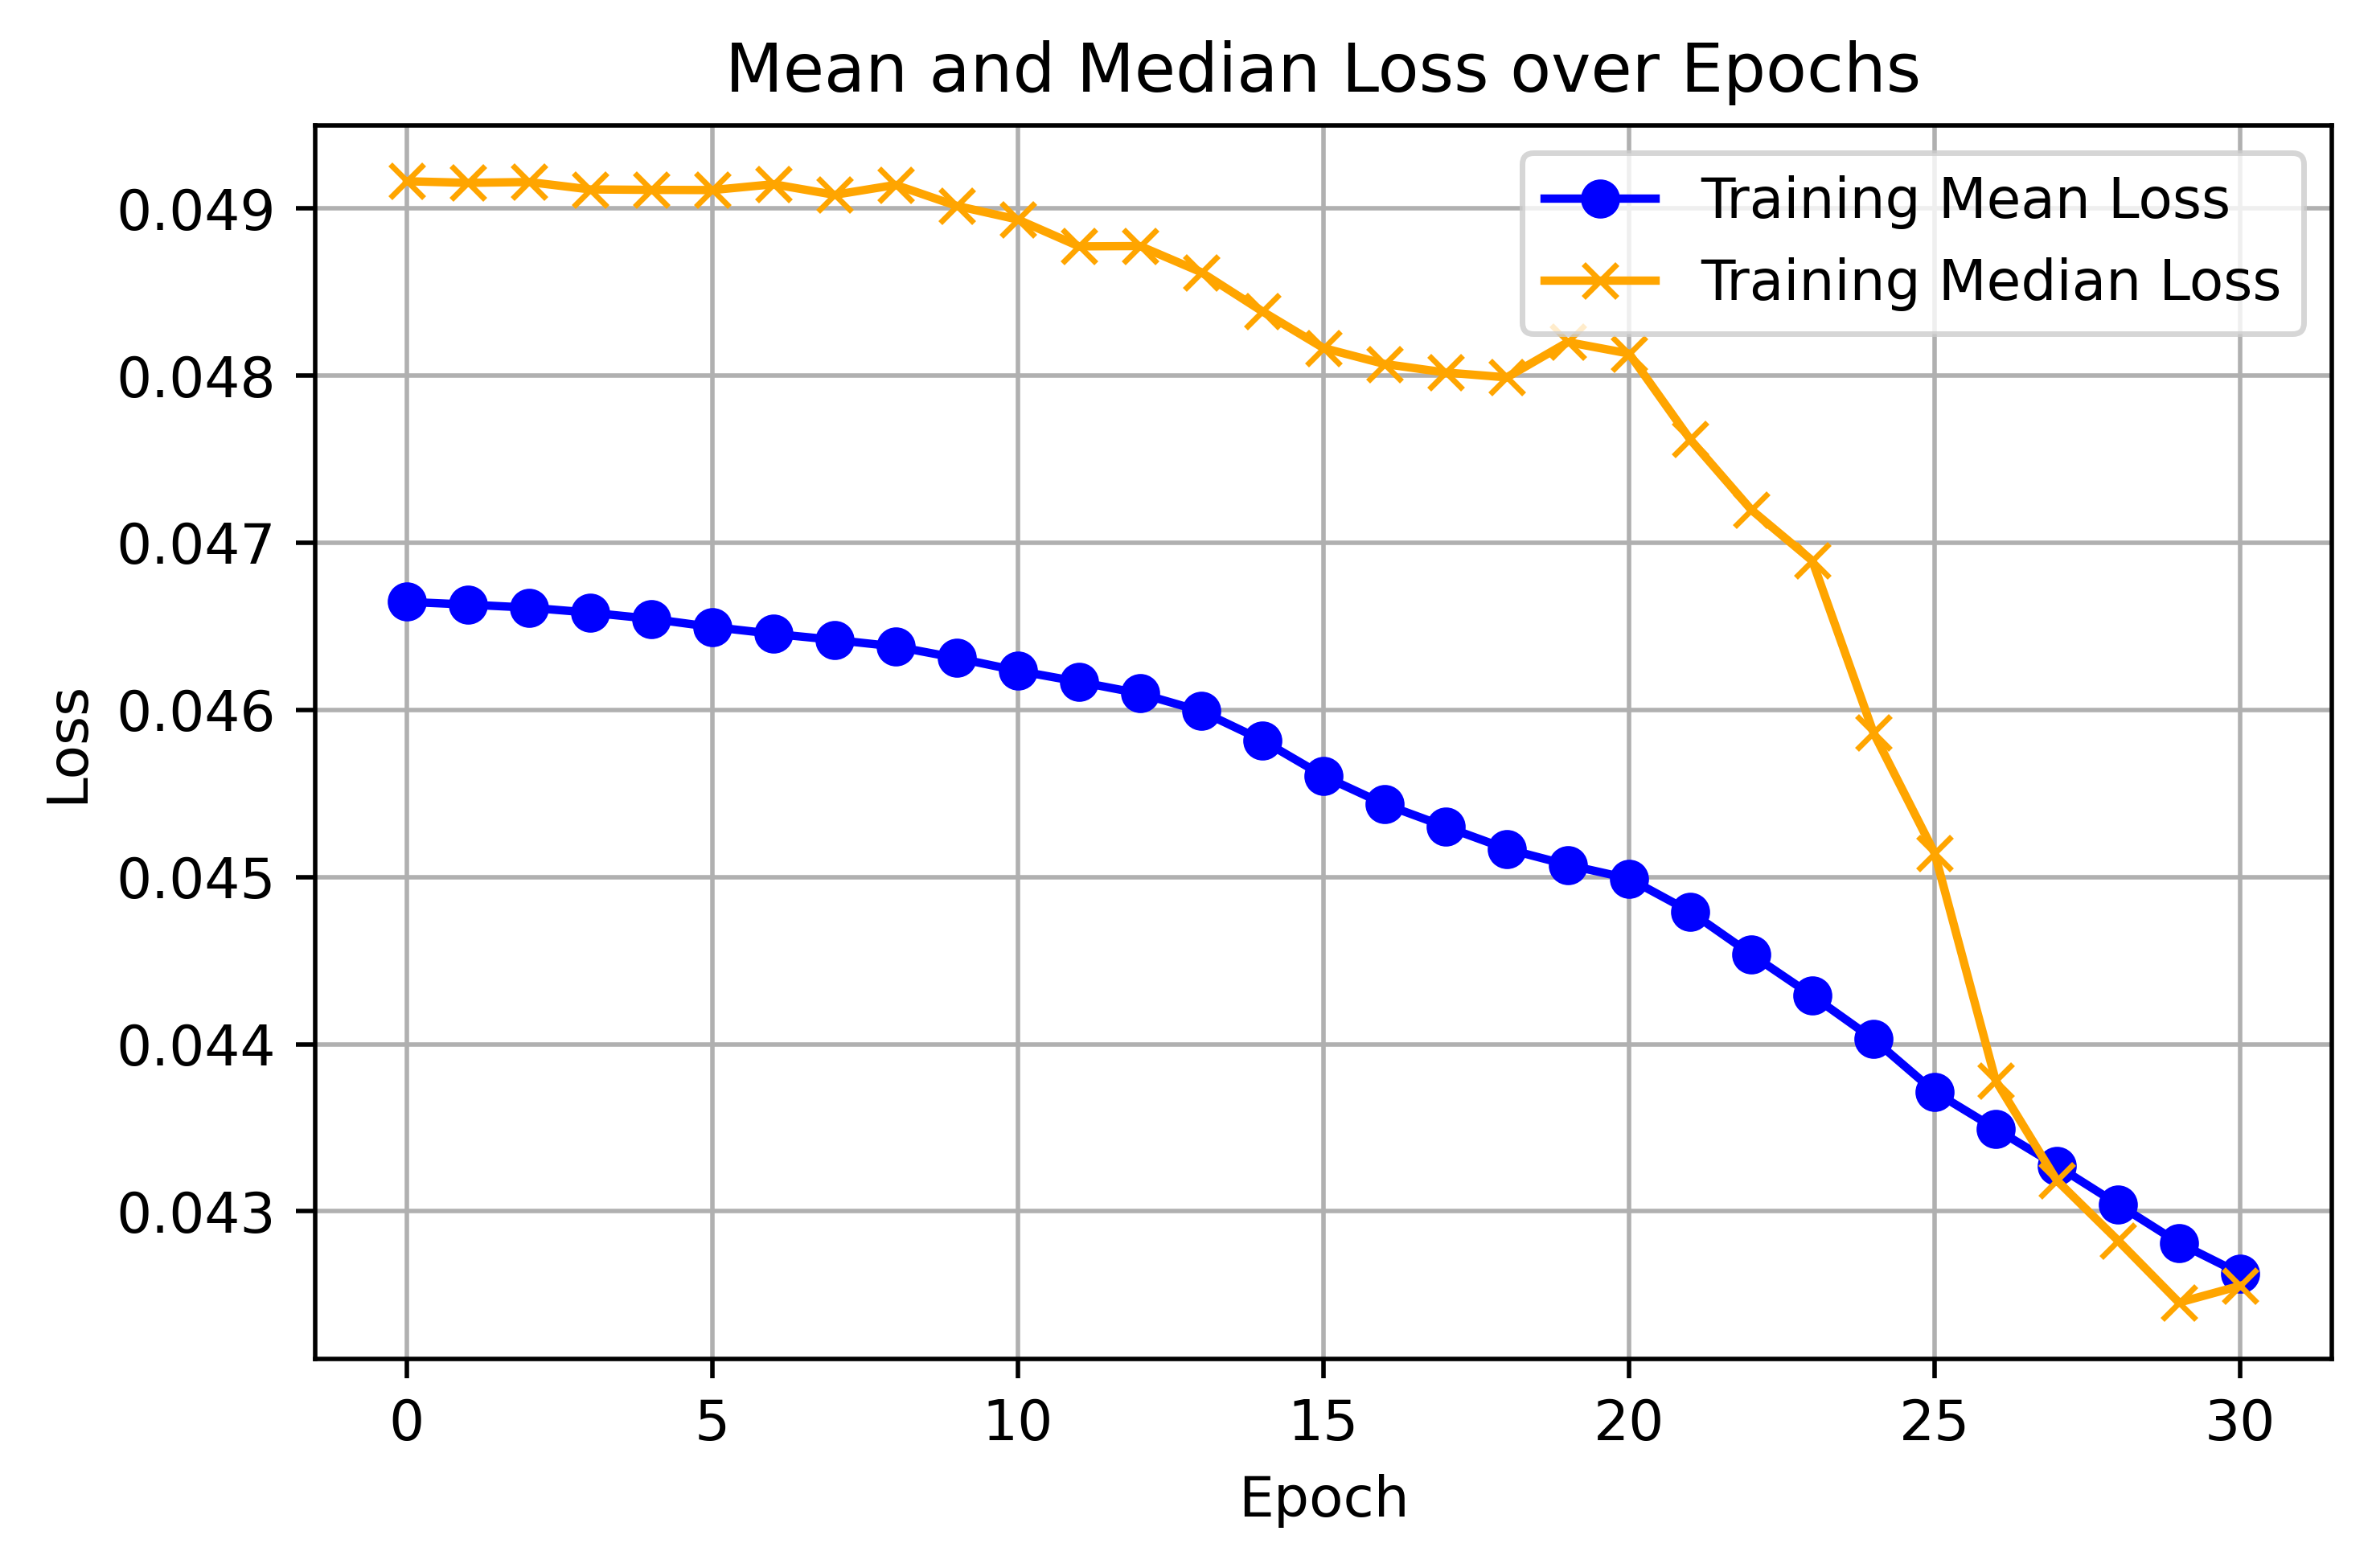

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


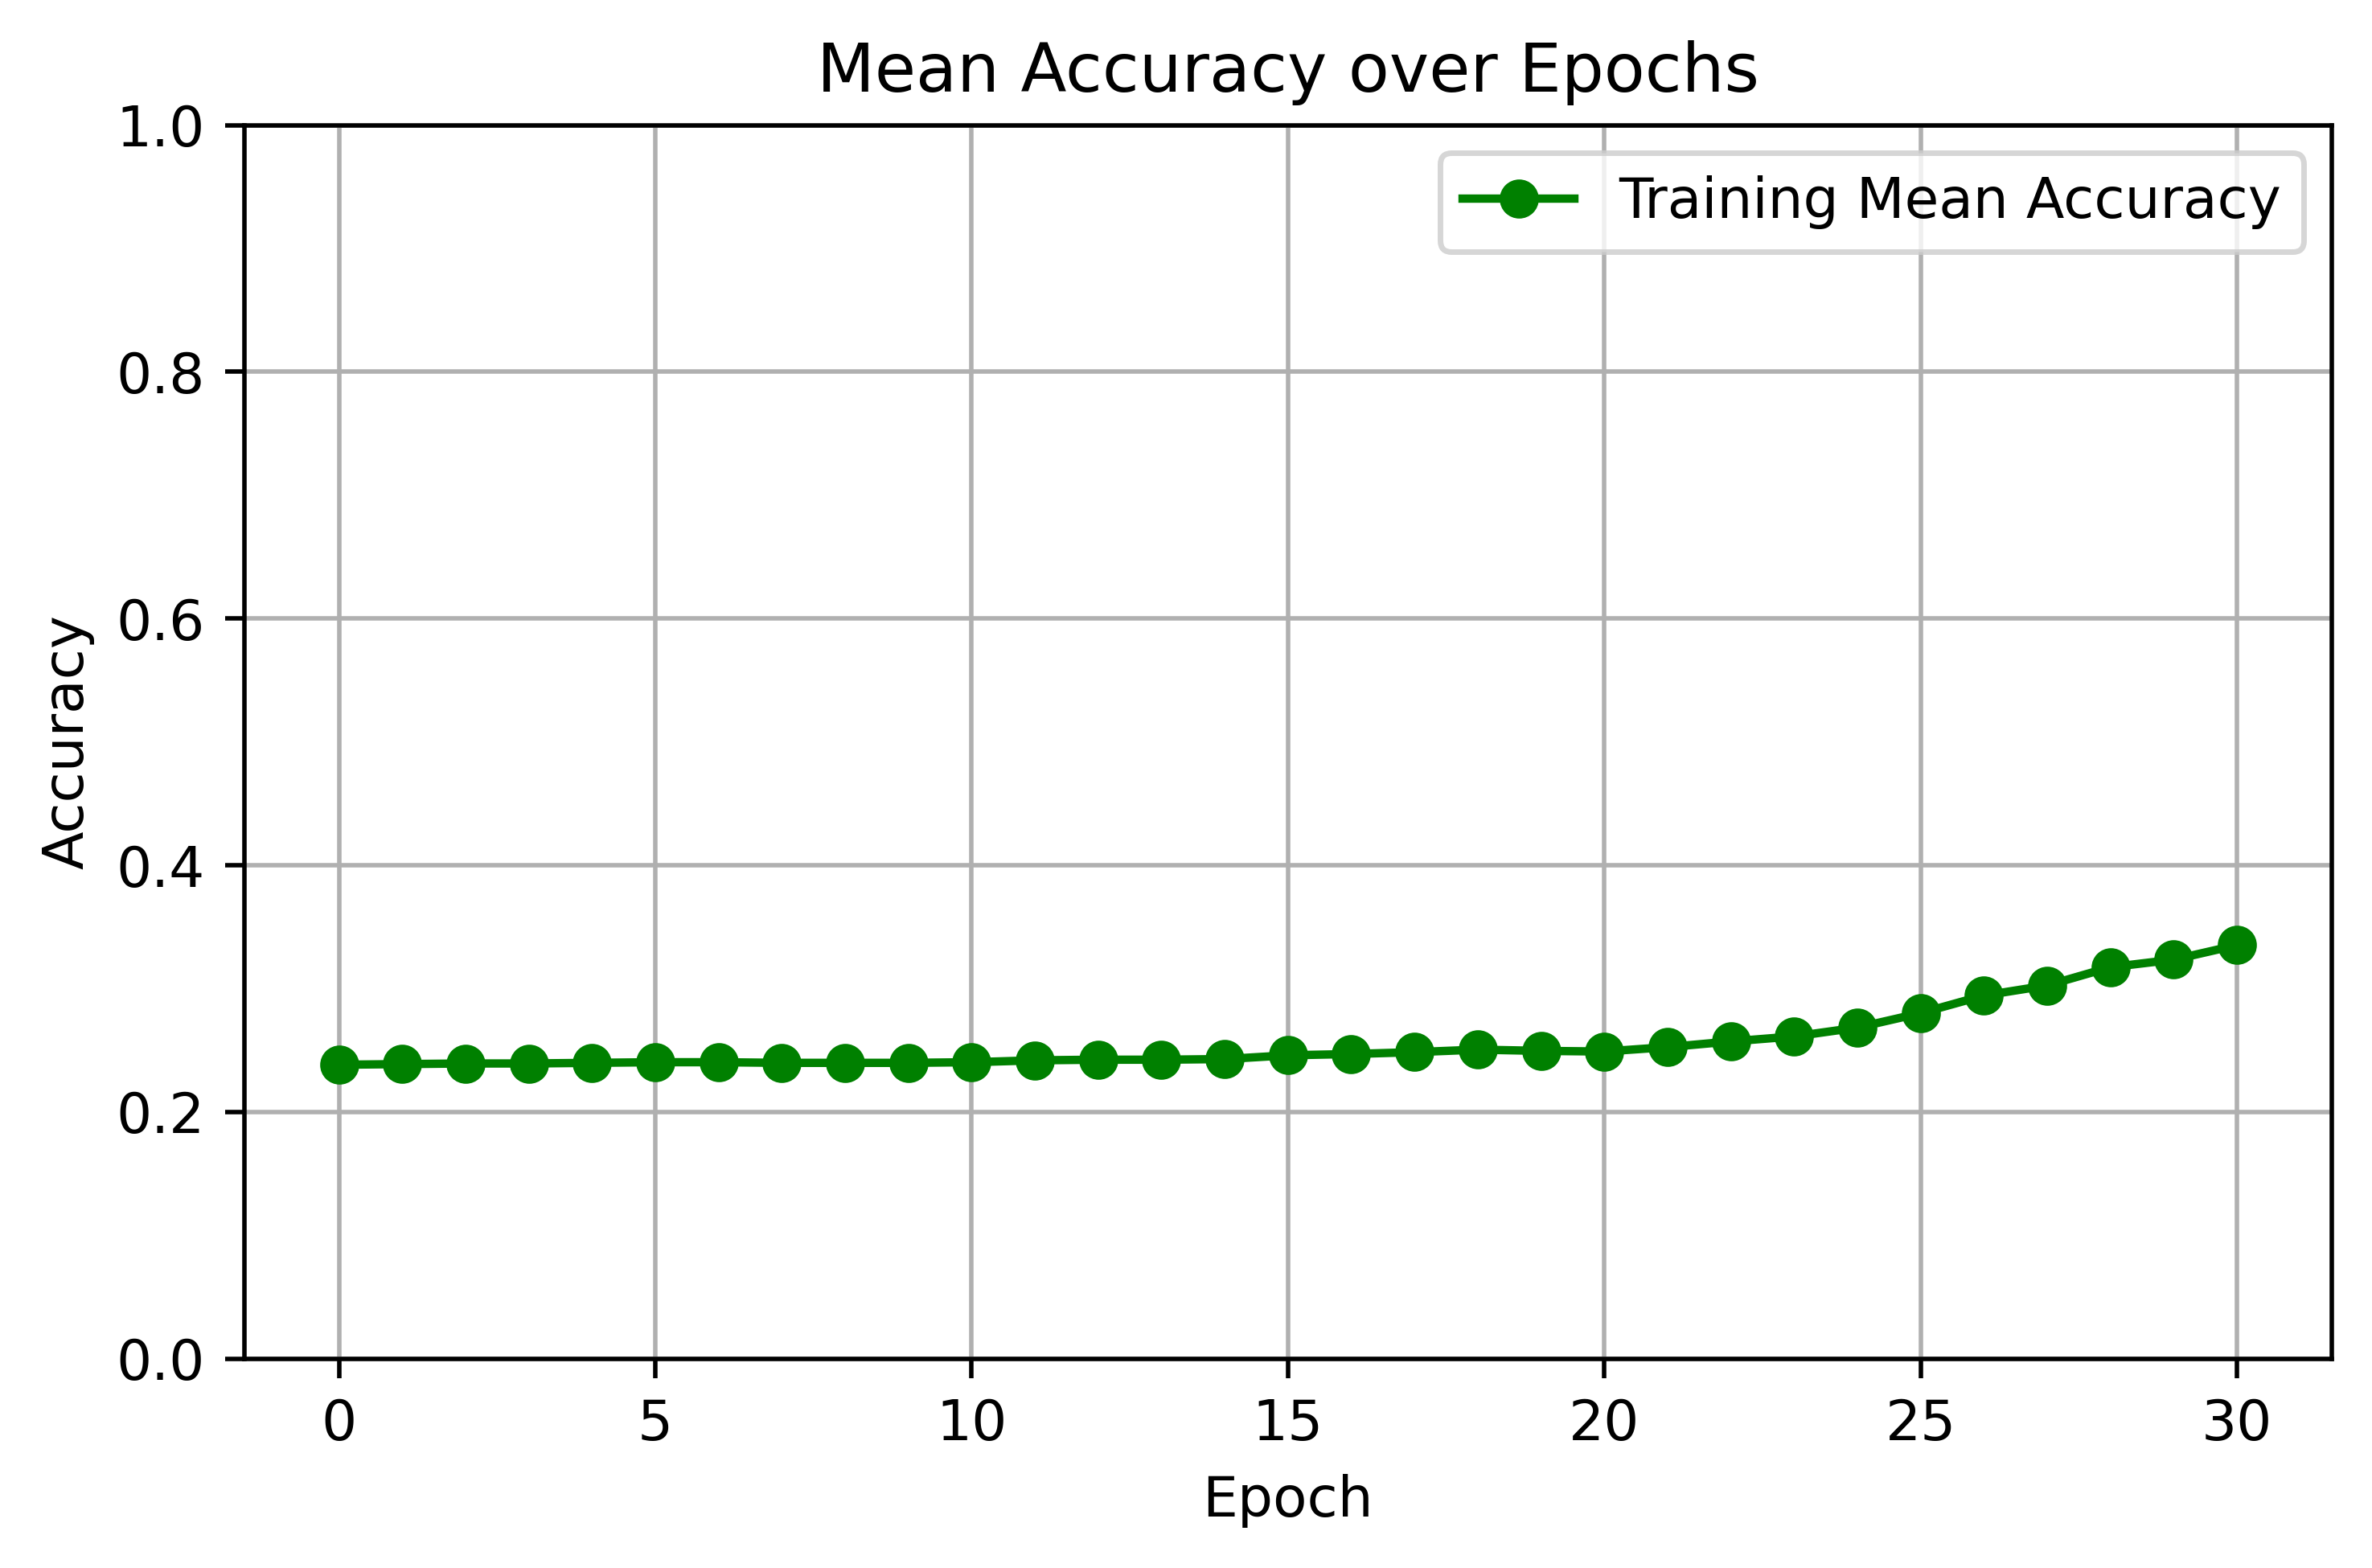

In [111]:
# Plot Mean Loss and Mean Accuracy

plt.figure(figsize=(6, 4), dpi=500)
plt.plot(df['Epoch'], df['Mean Loss'], marker='o', label=label_name+'Mean Loss', color='blue')
plt.plot(df['Epoch'], df['Median Loss'], marker='x', label=label_name+'Median Loss', color='orange')
plt.title('Mean and Median Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Show the second plot
plt.tight_layout()

plt.savefig(graphs_save_folder+"Training_Mean_Median_Loss_Graph.png", dpi=500, bbox_inches='tight')
plt.savefig(graphs_save_folder+"Training_Mean_Median_Loss_Graph.eps", dpi=500, bbox_inches='tight')
plt.savefig(graphs_save_folder+"Training_Mean_Median_Loss_Graph.pdf", dpi=500, bbox_inches='tight')

plt.show()

plt.figure(figsize=(6, 4), dpi=500)
plt.plot(df['Epoch'], df['Mean Accuracy'], marker='o', label=label_name+'Mean Accuracy', color='green')
plt.title('Mean Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim(0, 1)  # Assuming accuracy is between 0 and 1

plt.legend()

plt.grid(True)

# Show the second plot
plt.tight_layout()
plt.savefig(graphs_save_folder+"Training_Mean_Accuracy_Graph.png", dpi=500, bbox_inches='tight')
plt.savefig(graphs_save_folder+"Training_Mean_Accuracy_Graph.eps", dpi=500, bbox_inches='tight')
plt.savefig(graphs_save_folder+"Training_Mean_Accuracy_Graph.pdf", dpi=500, bbox_inches='tight')
plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


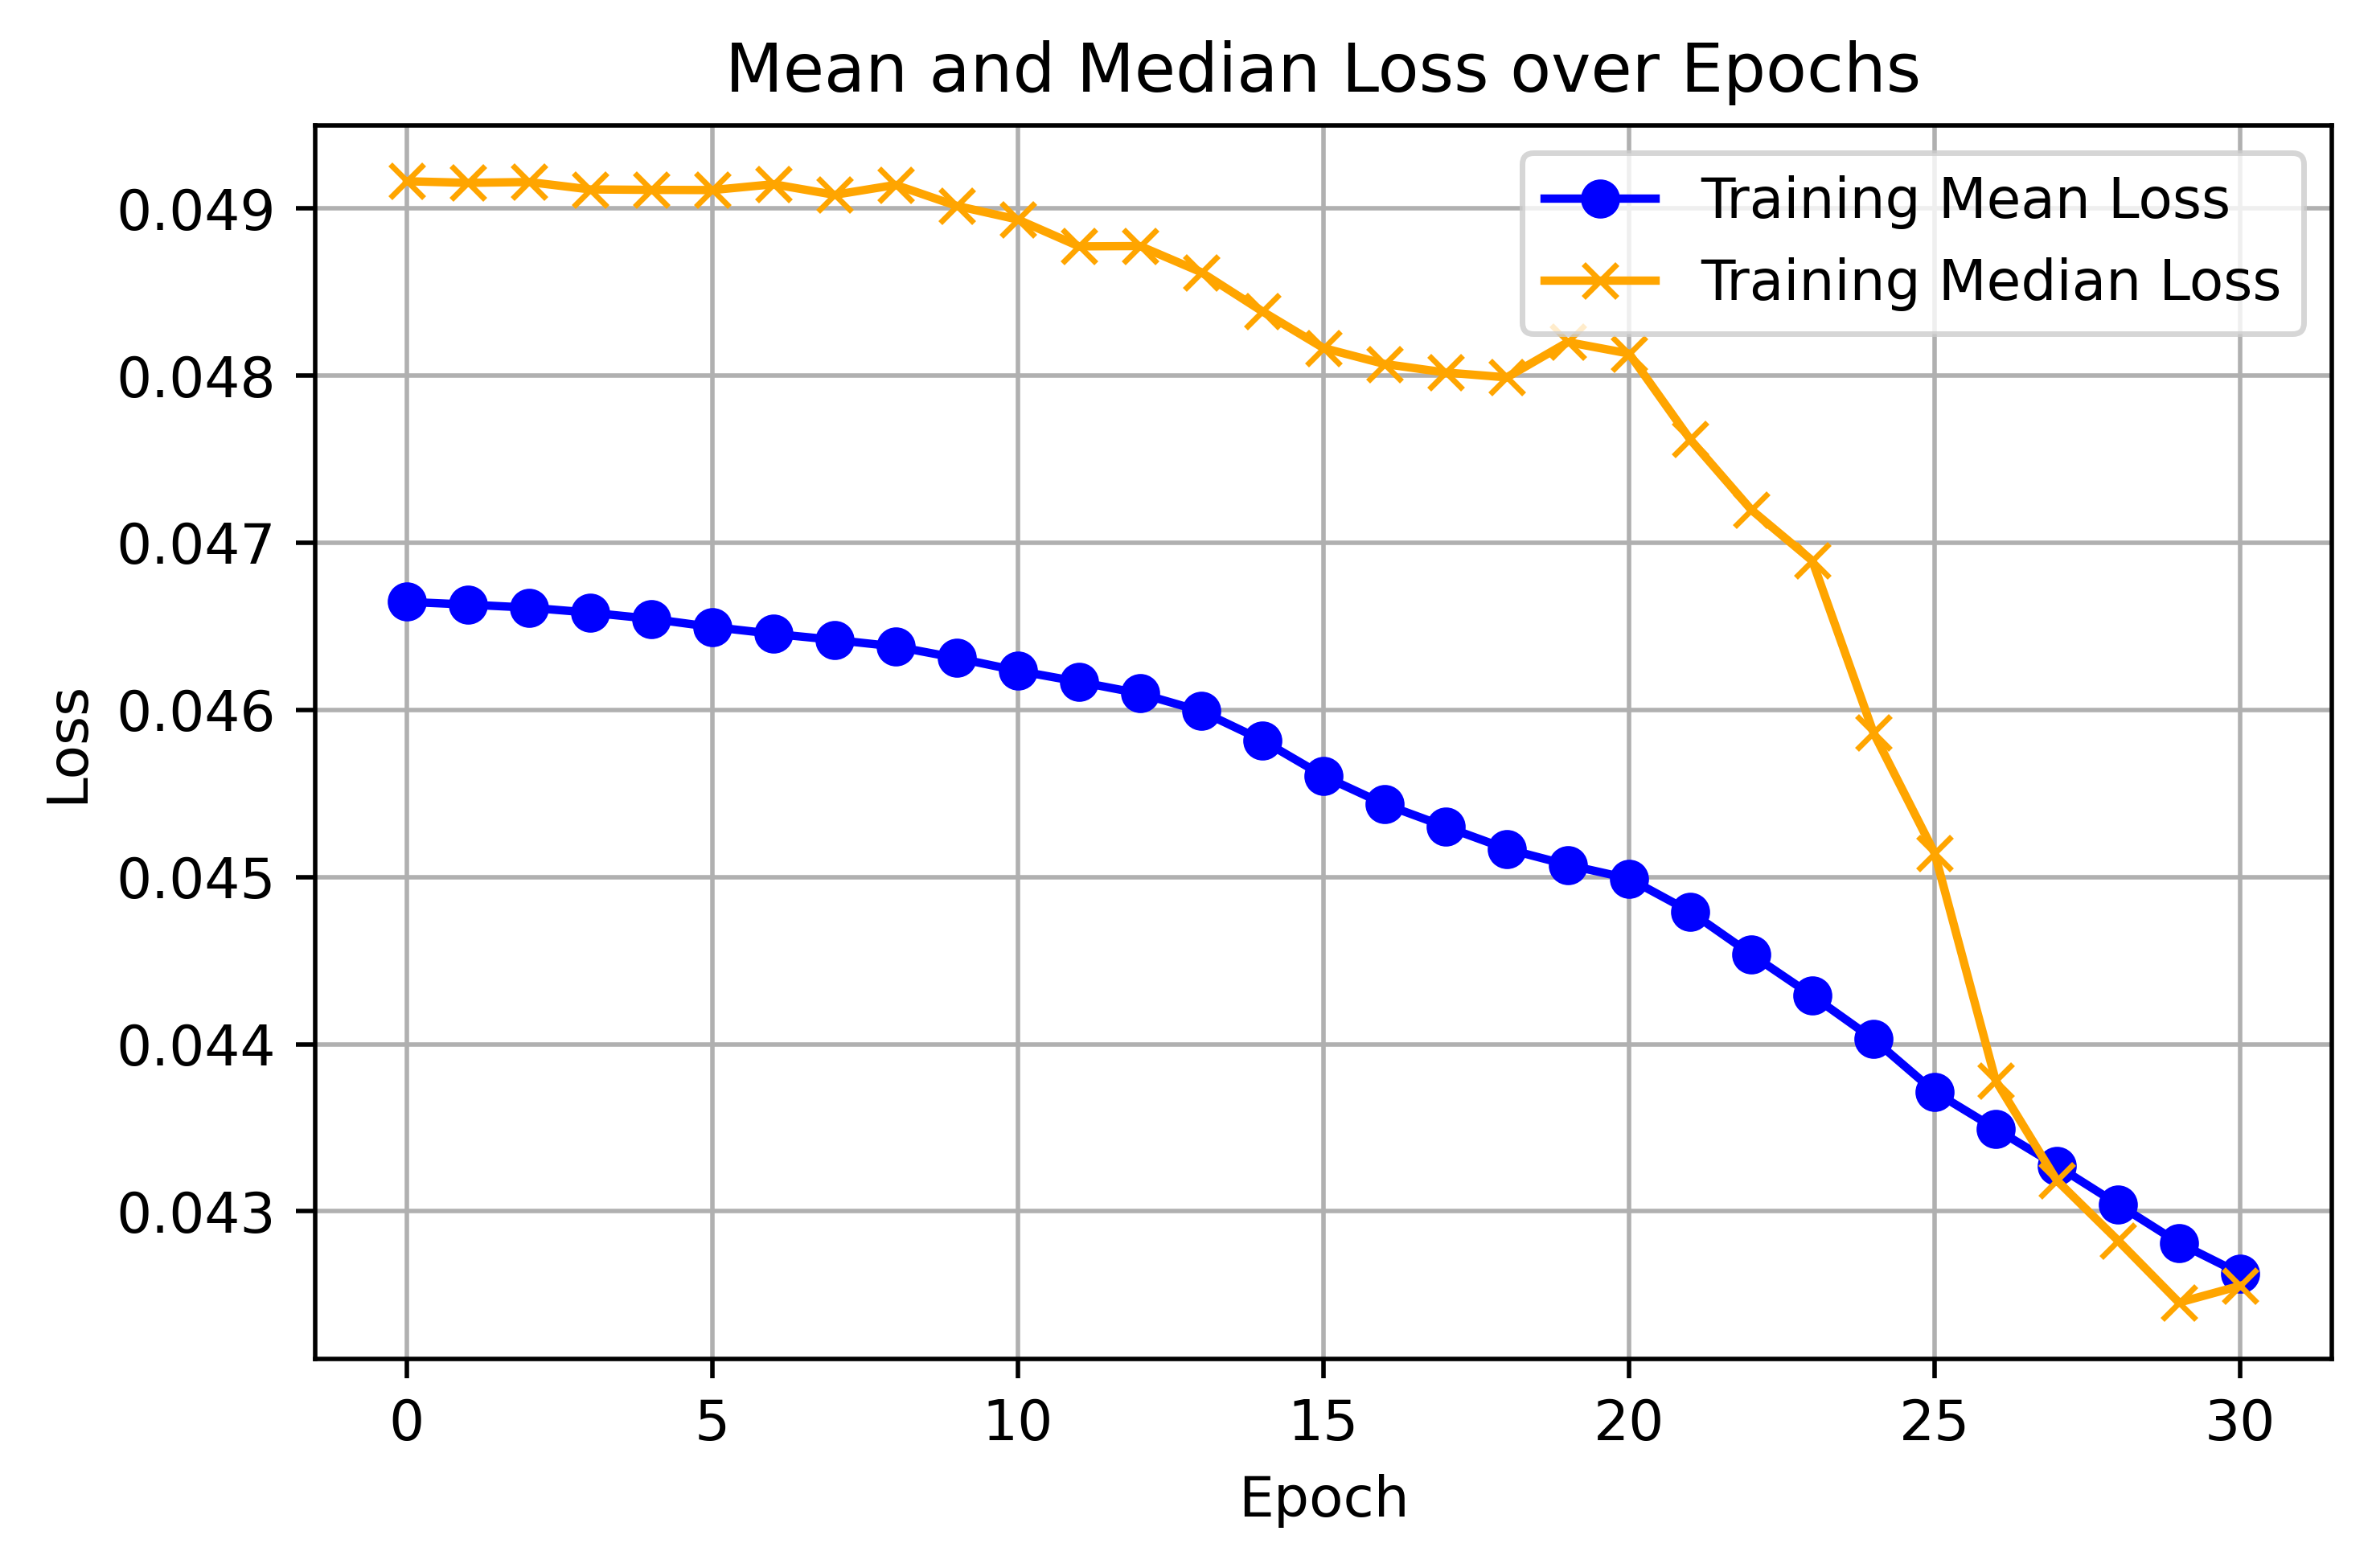

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


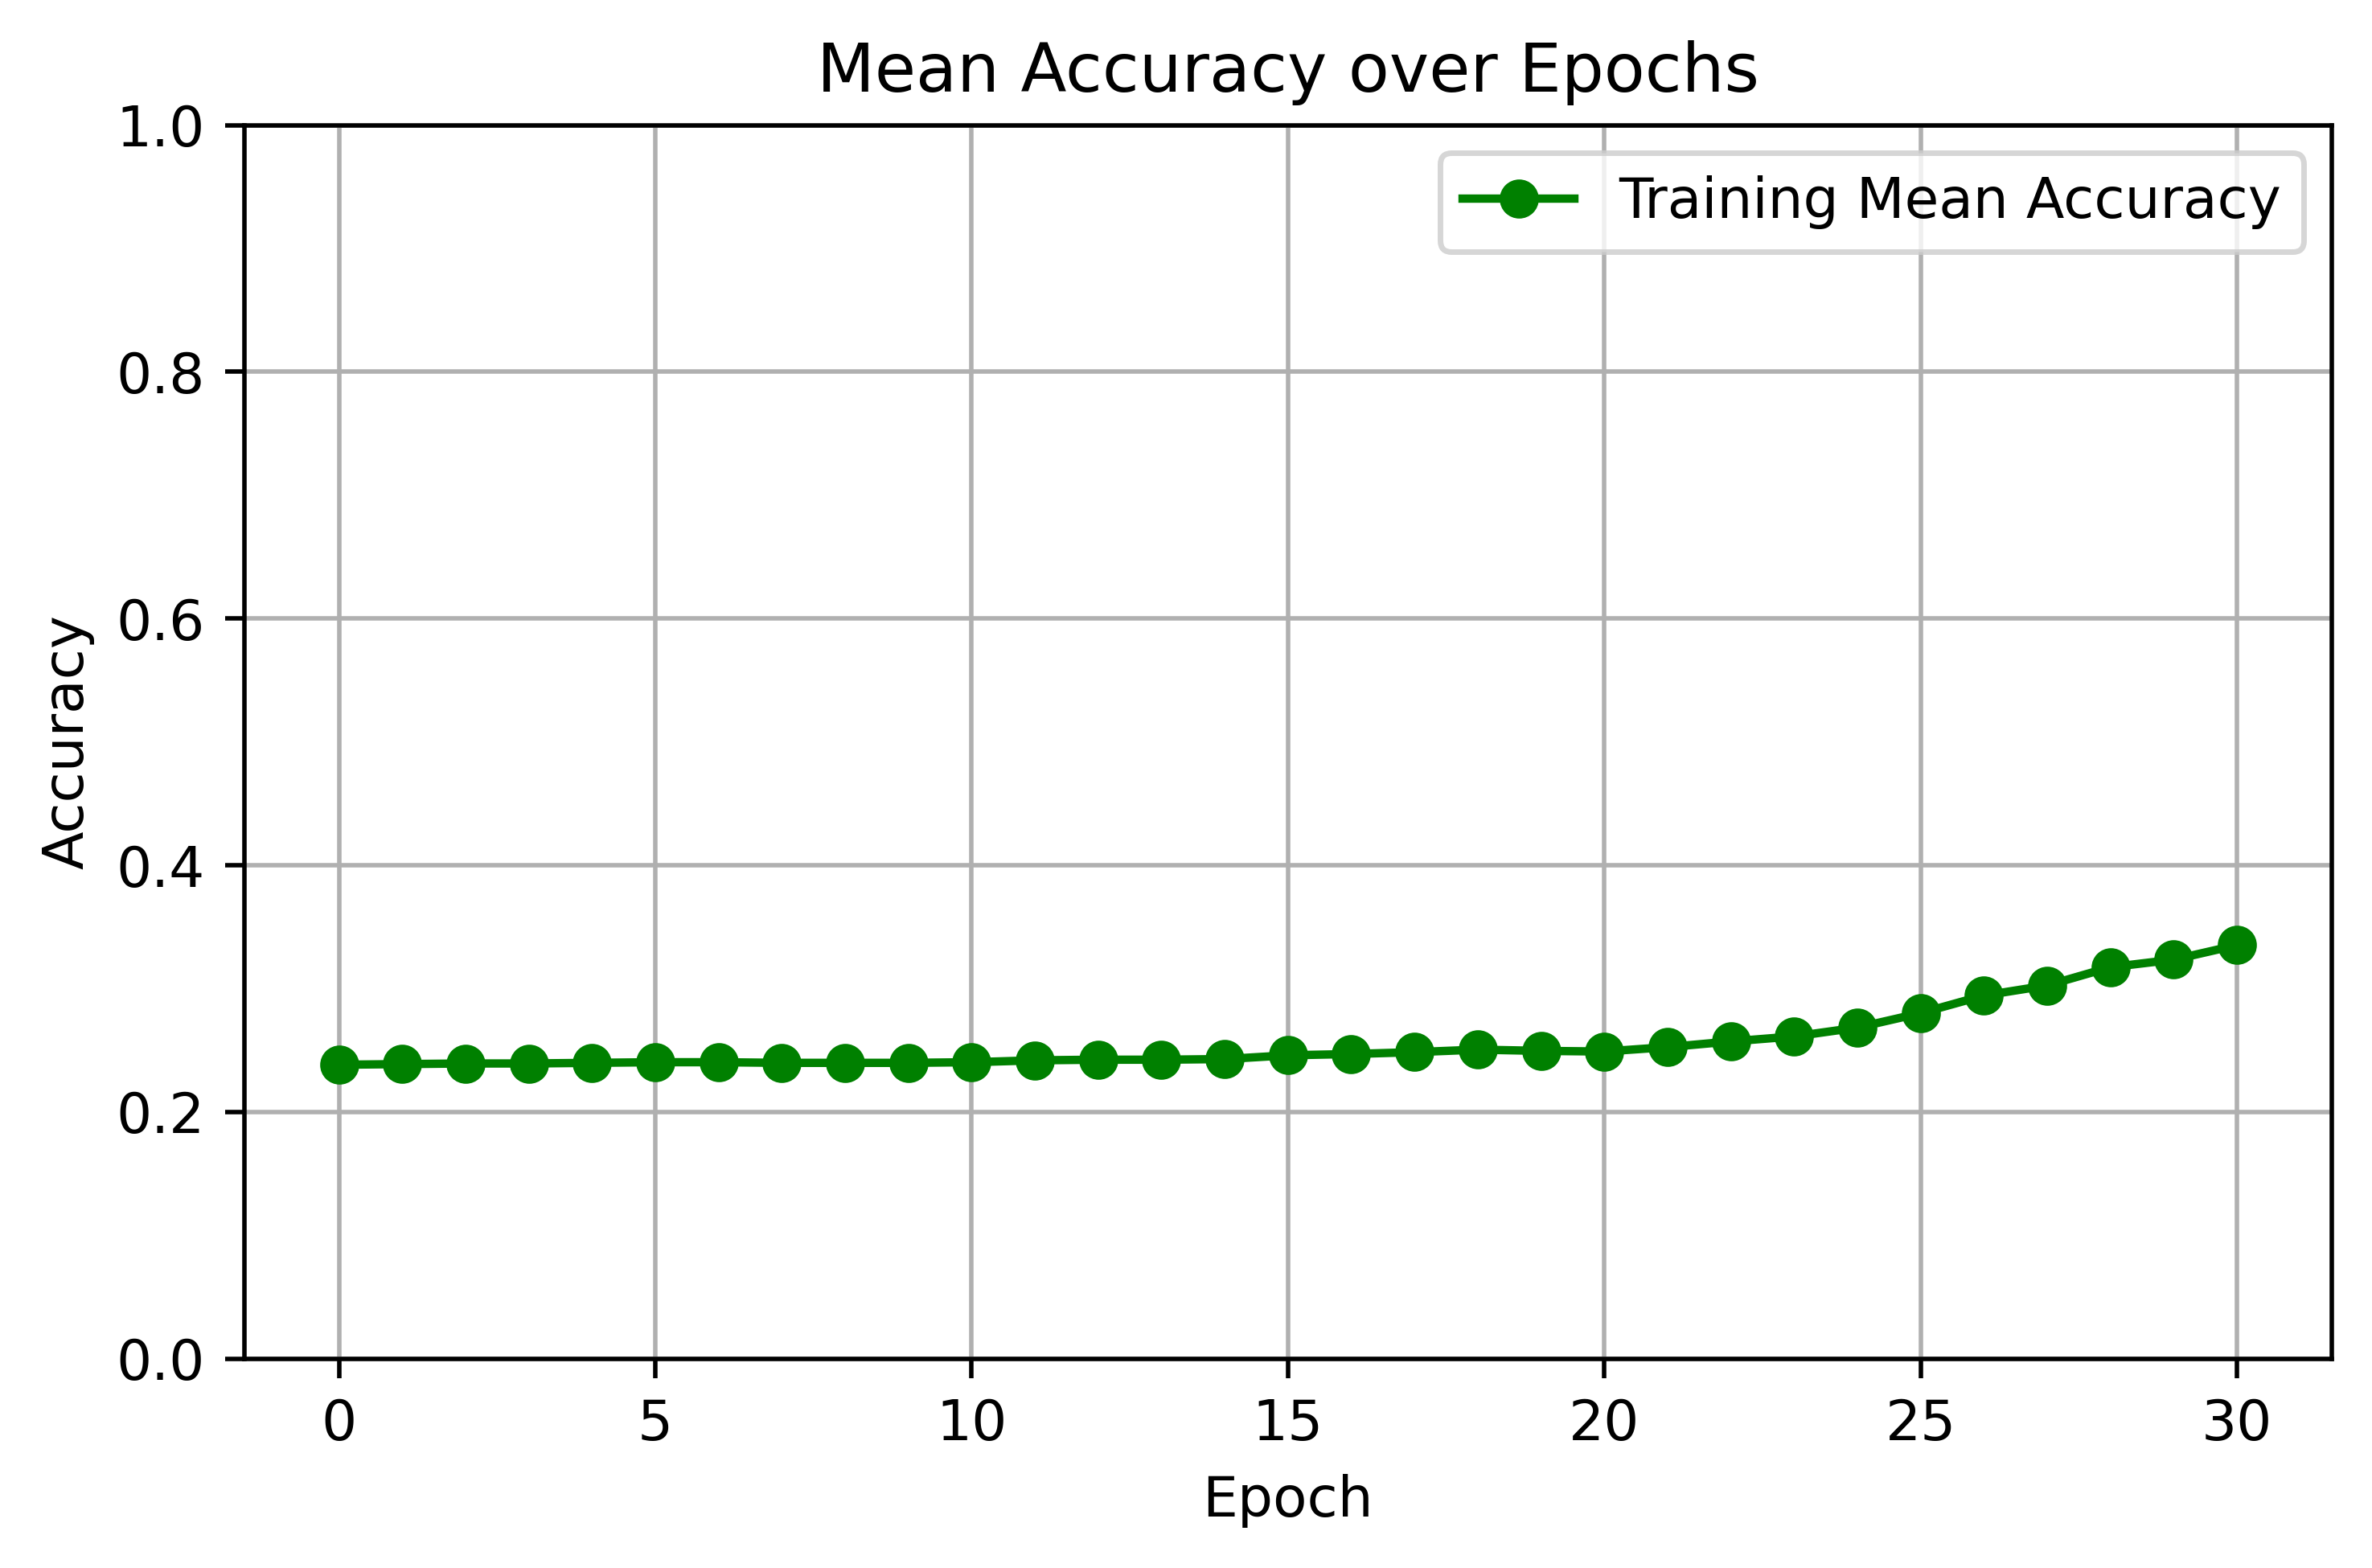

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


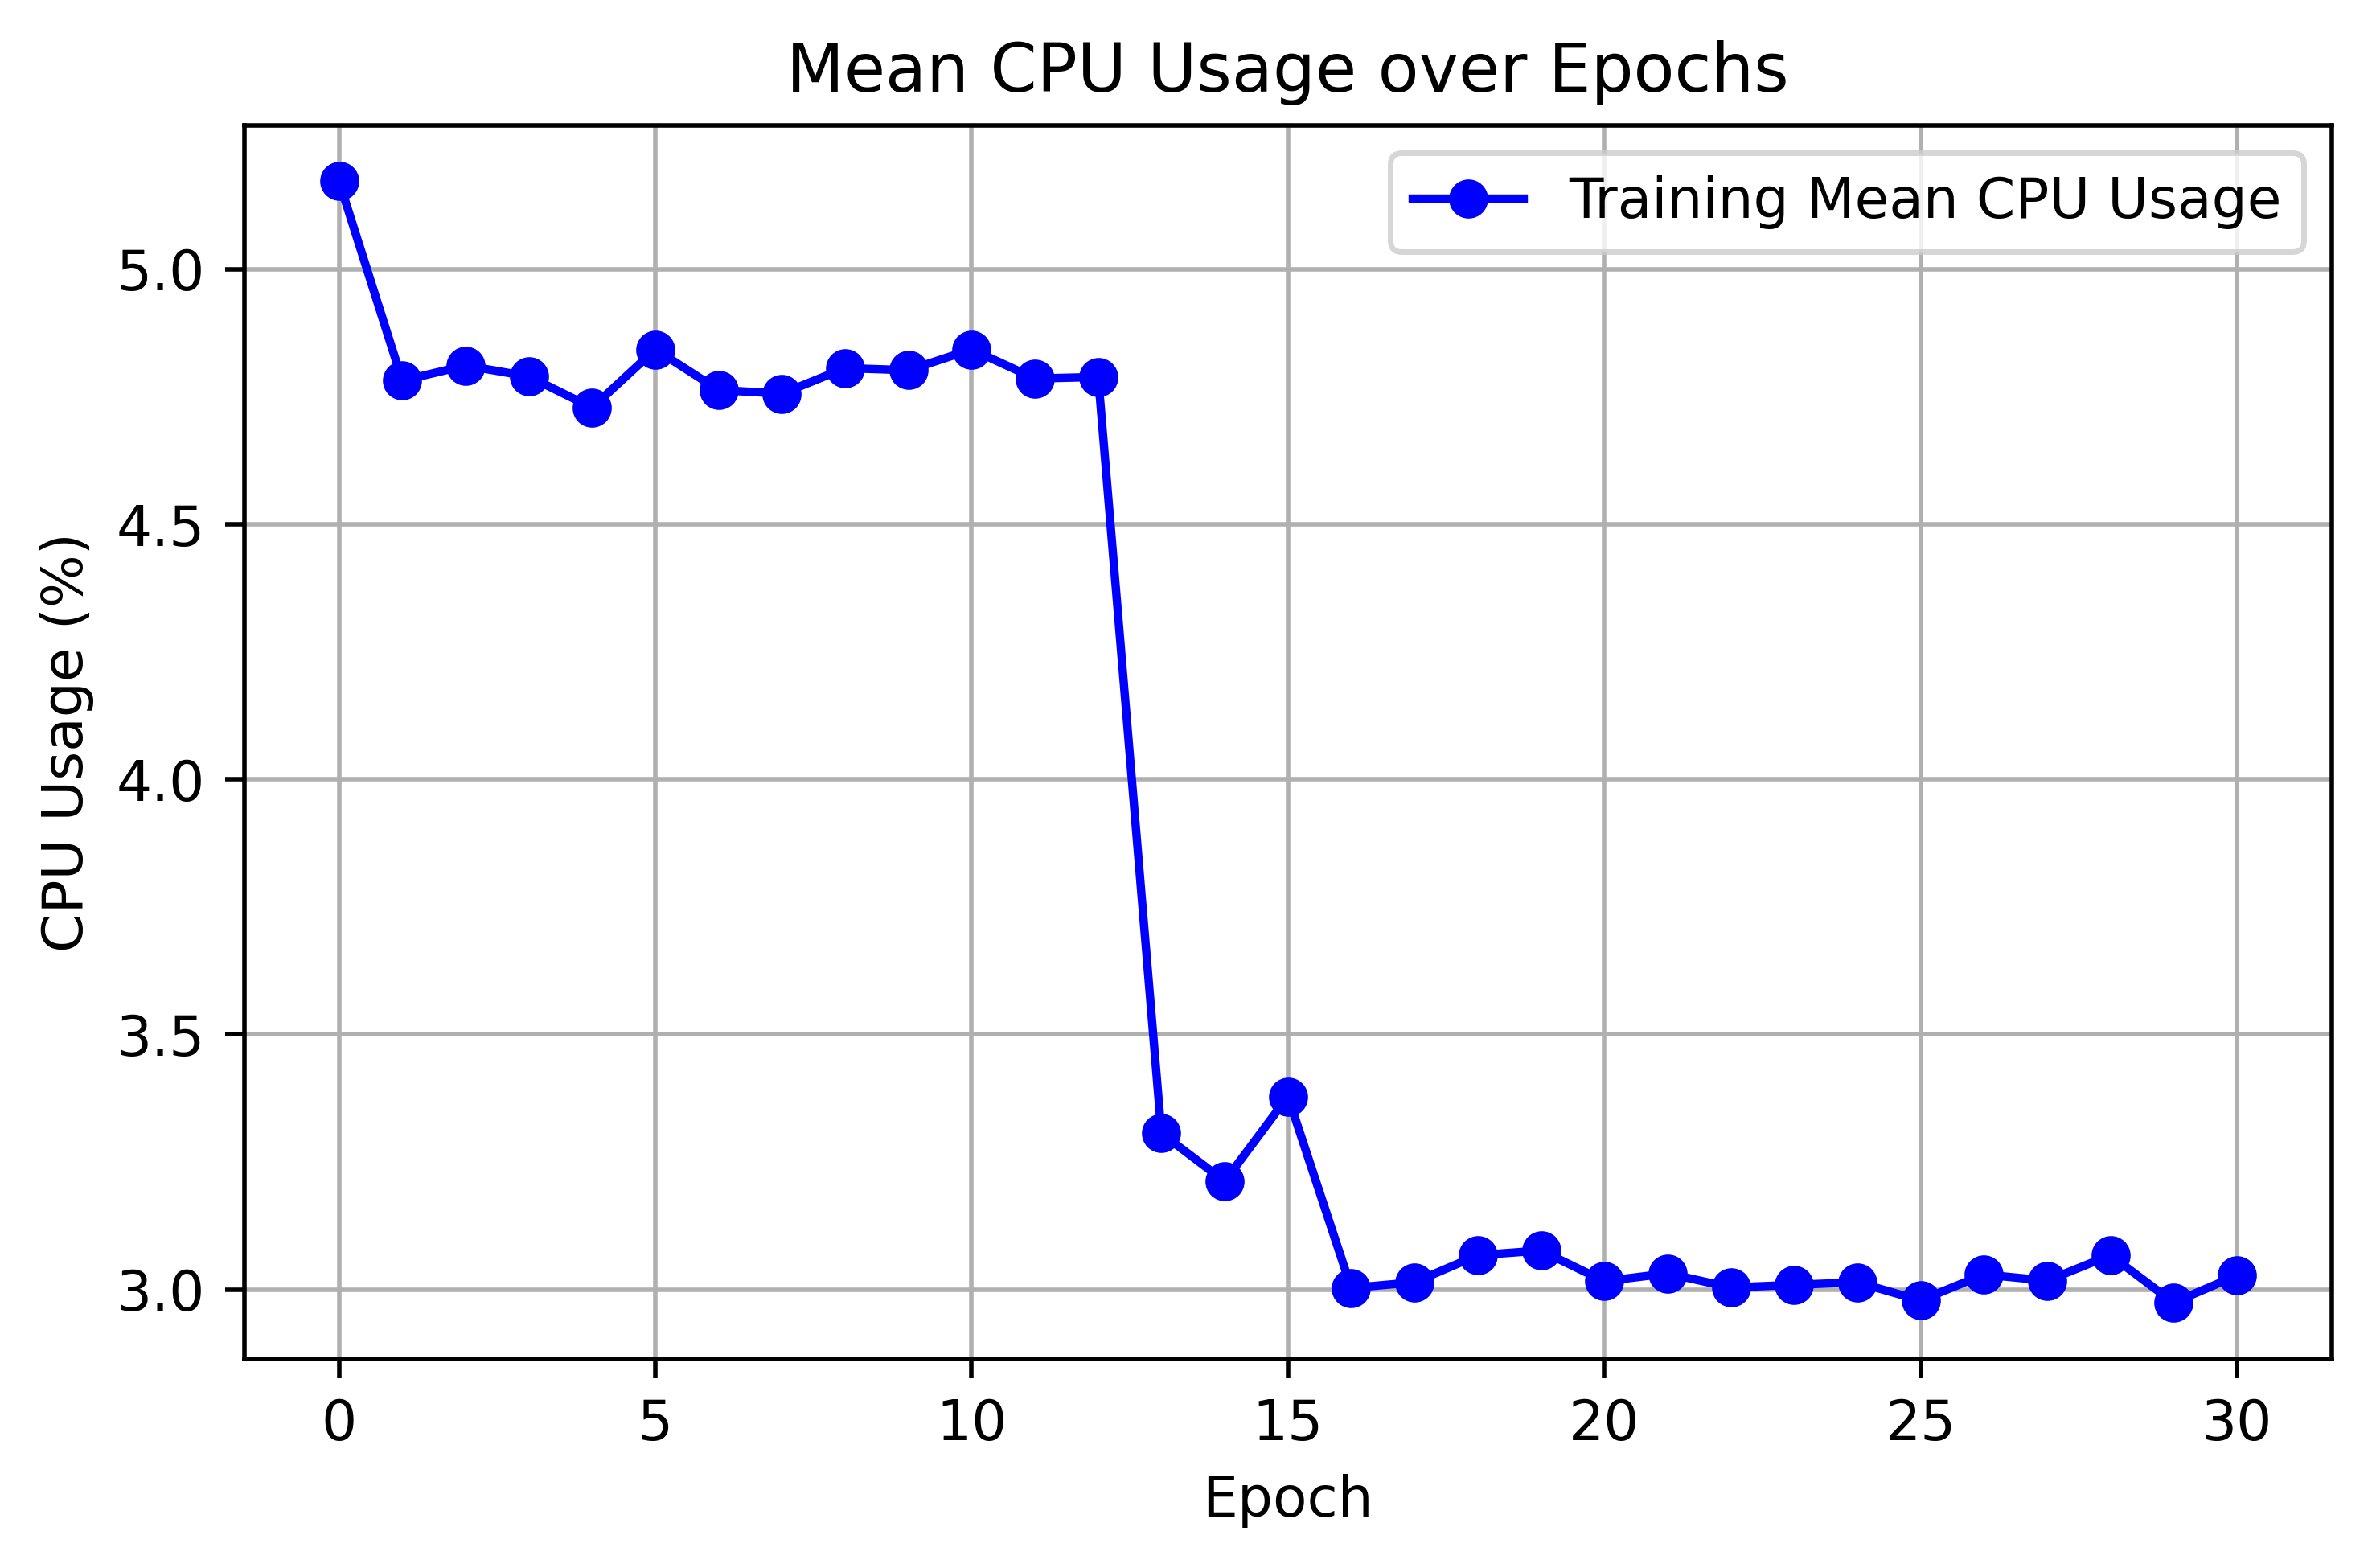

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


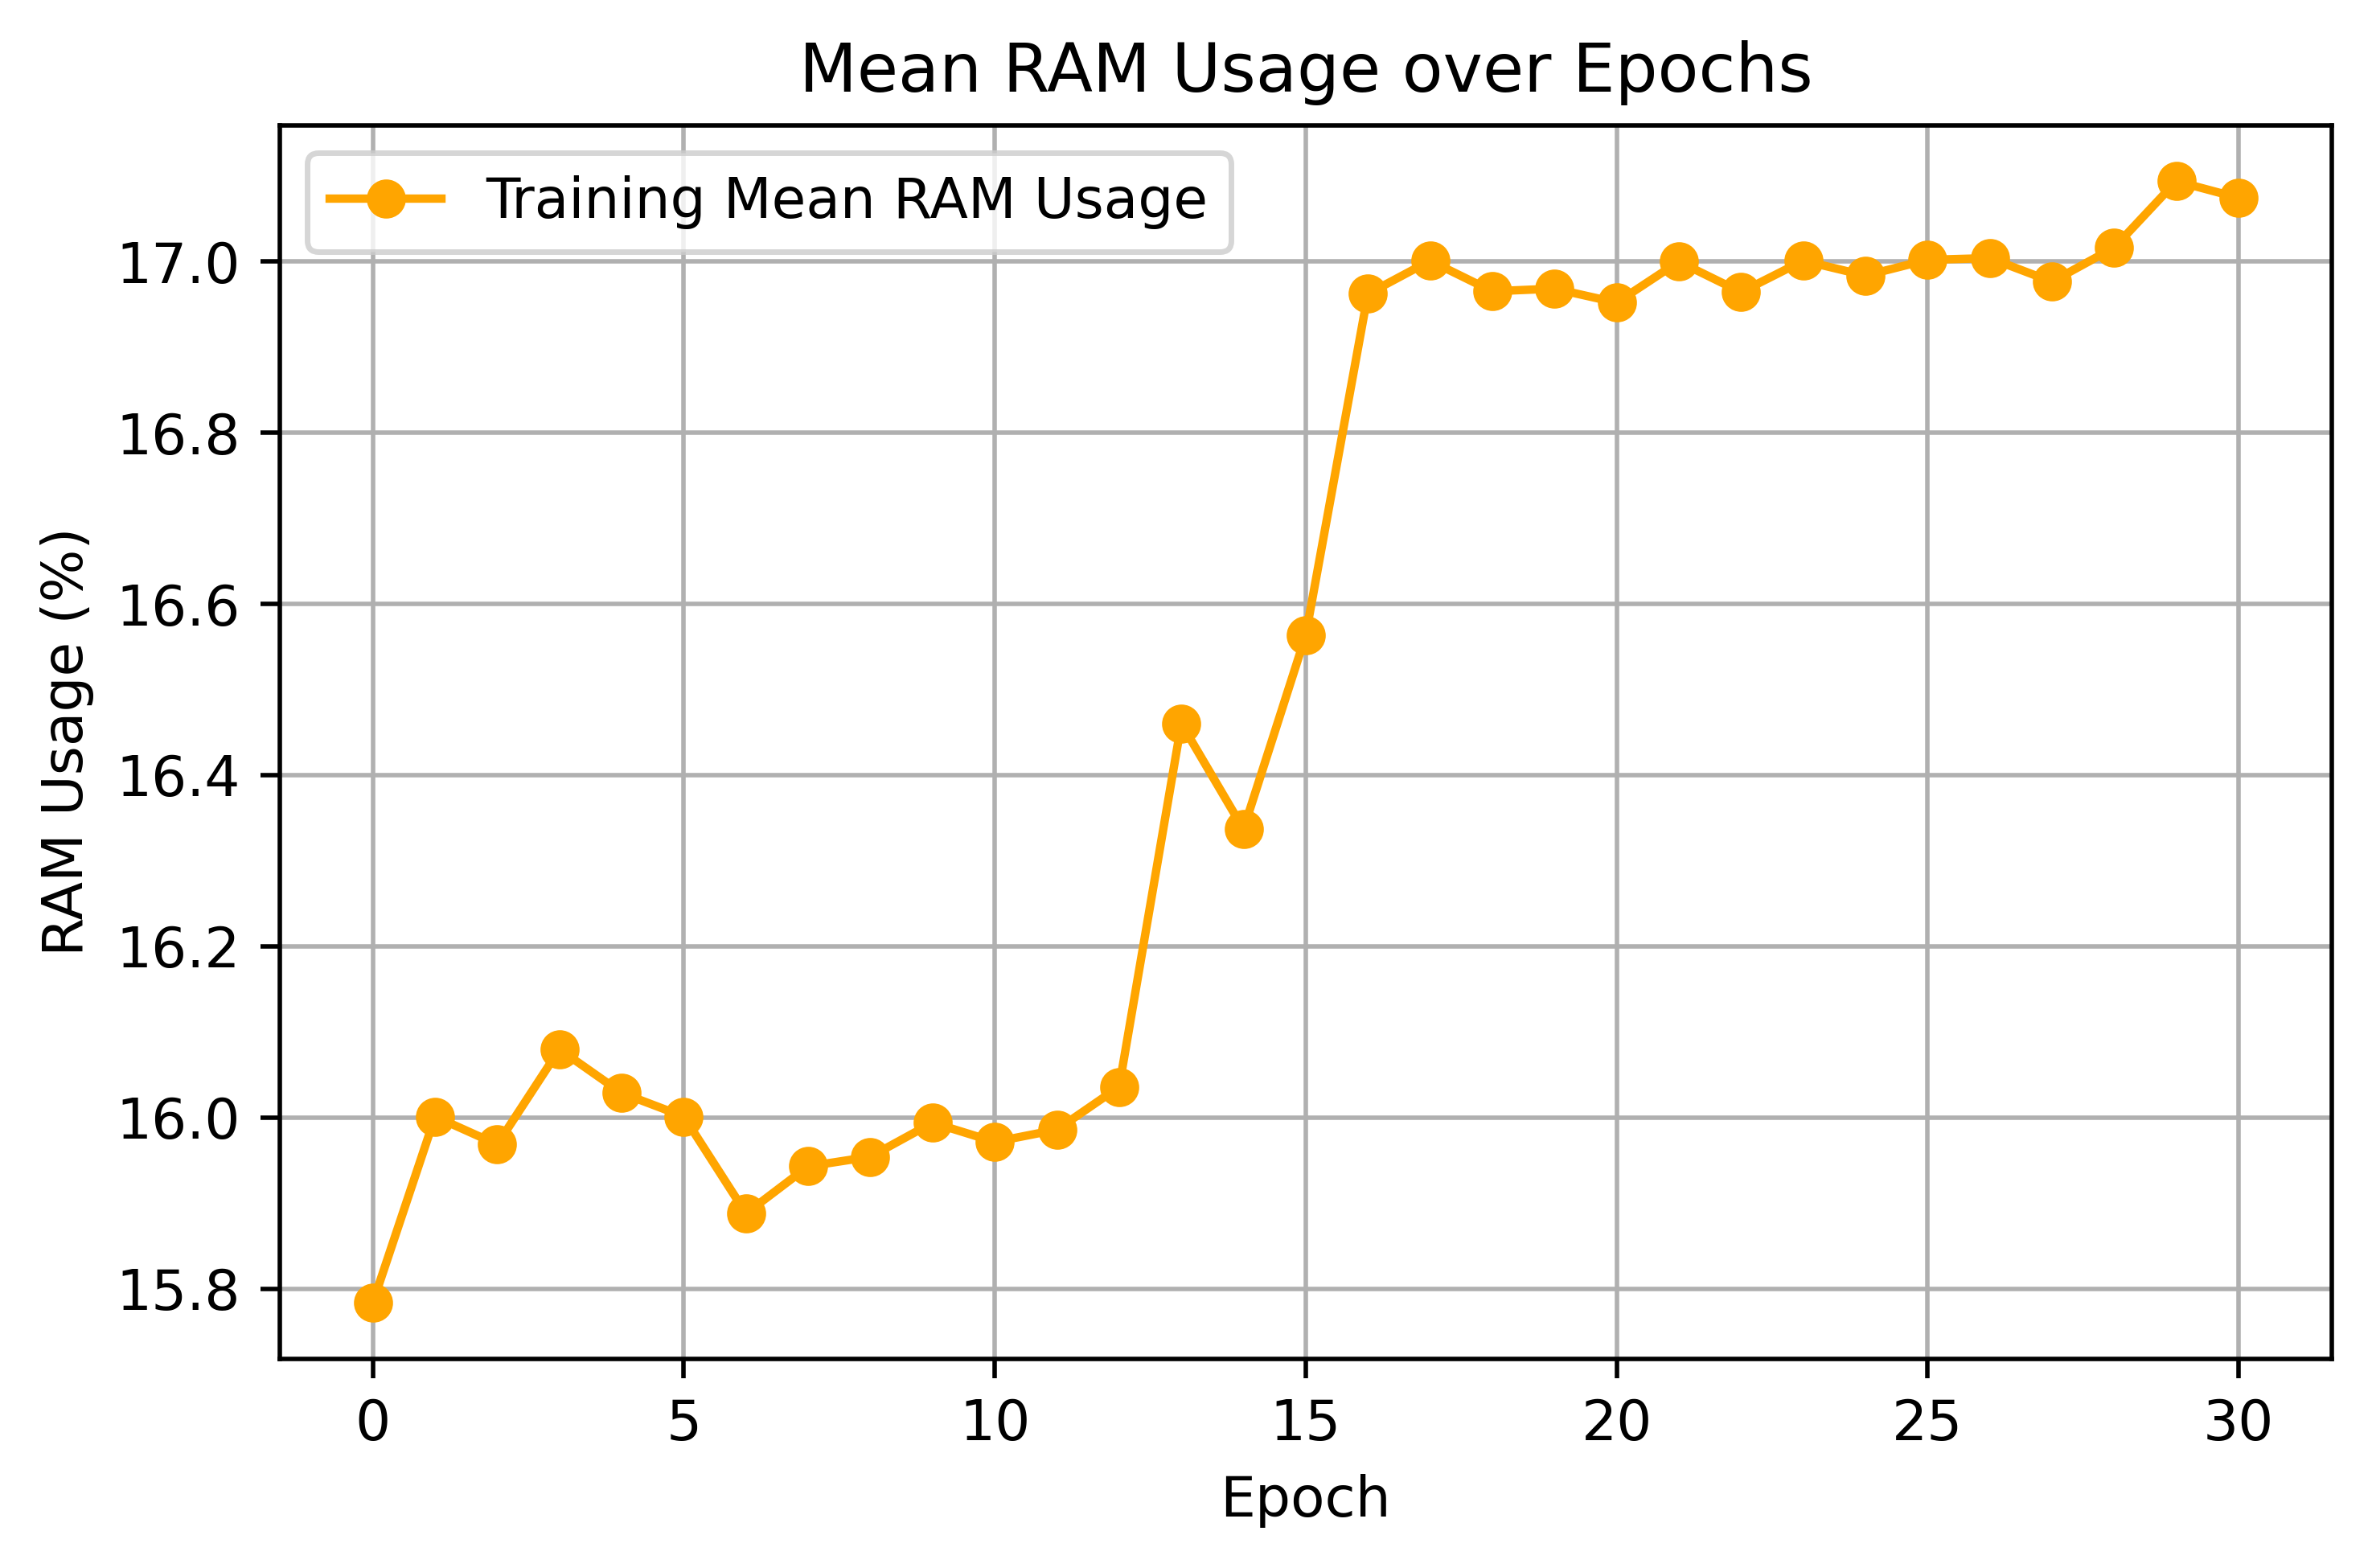

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


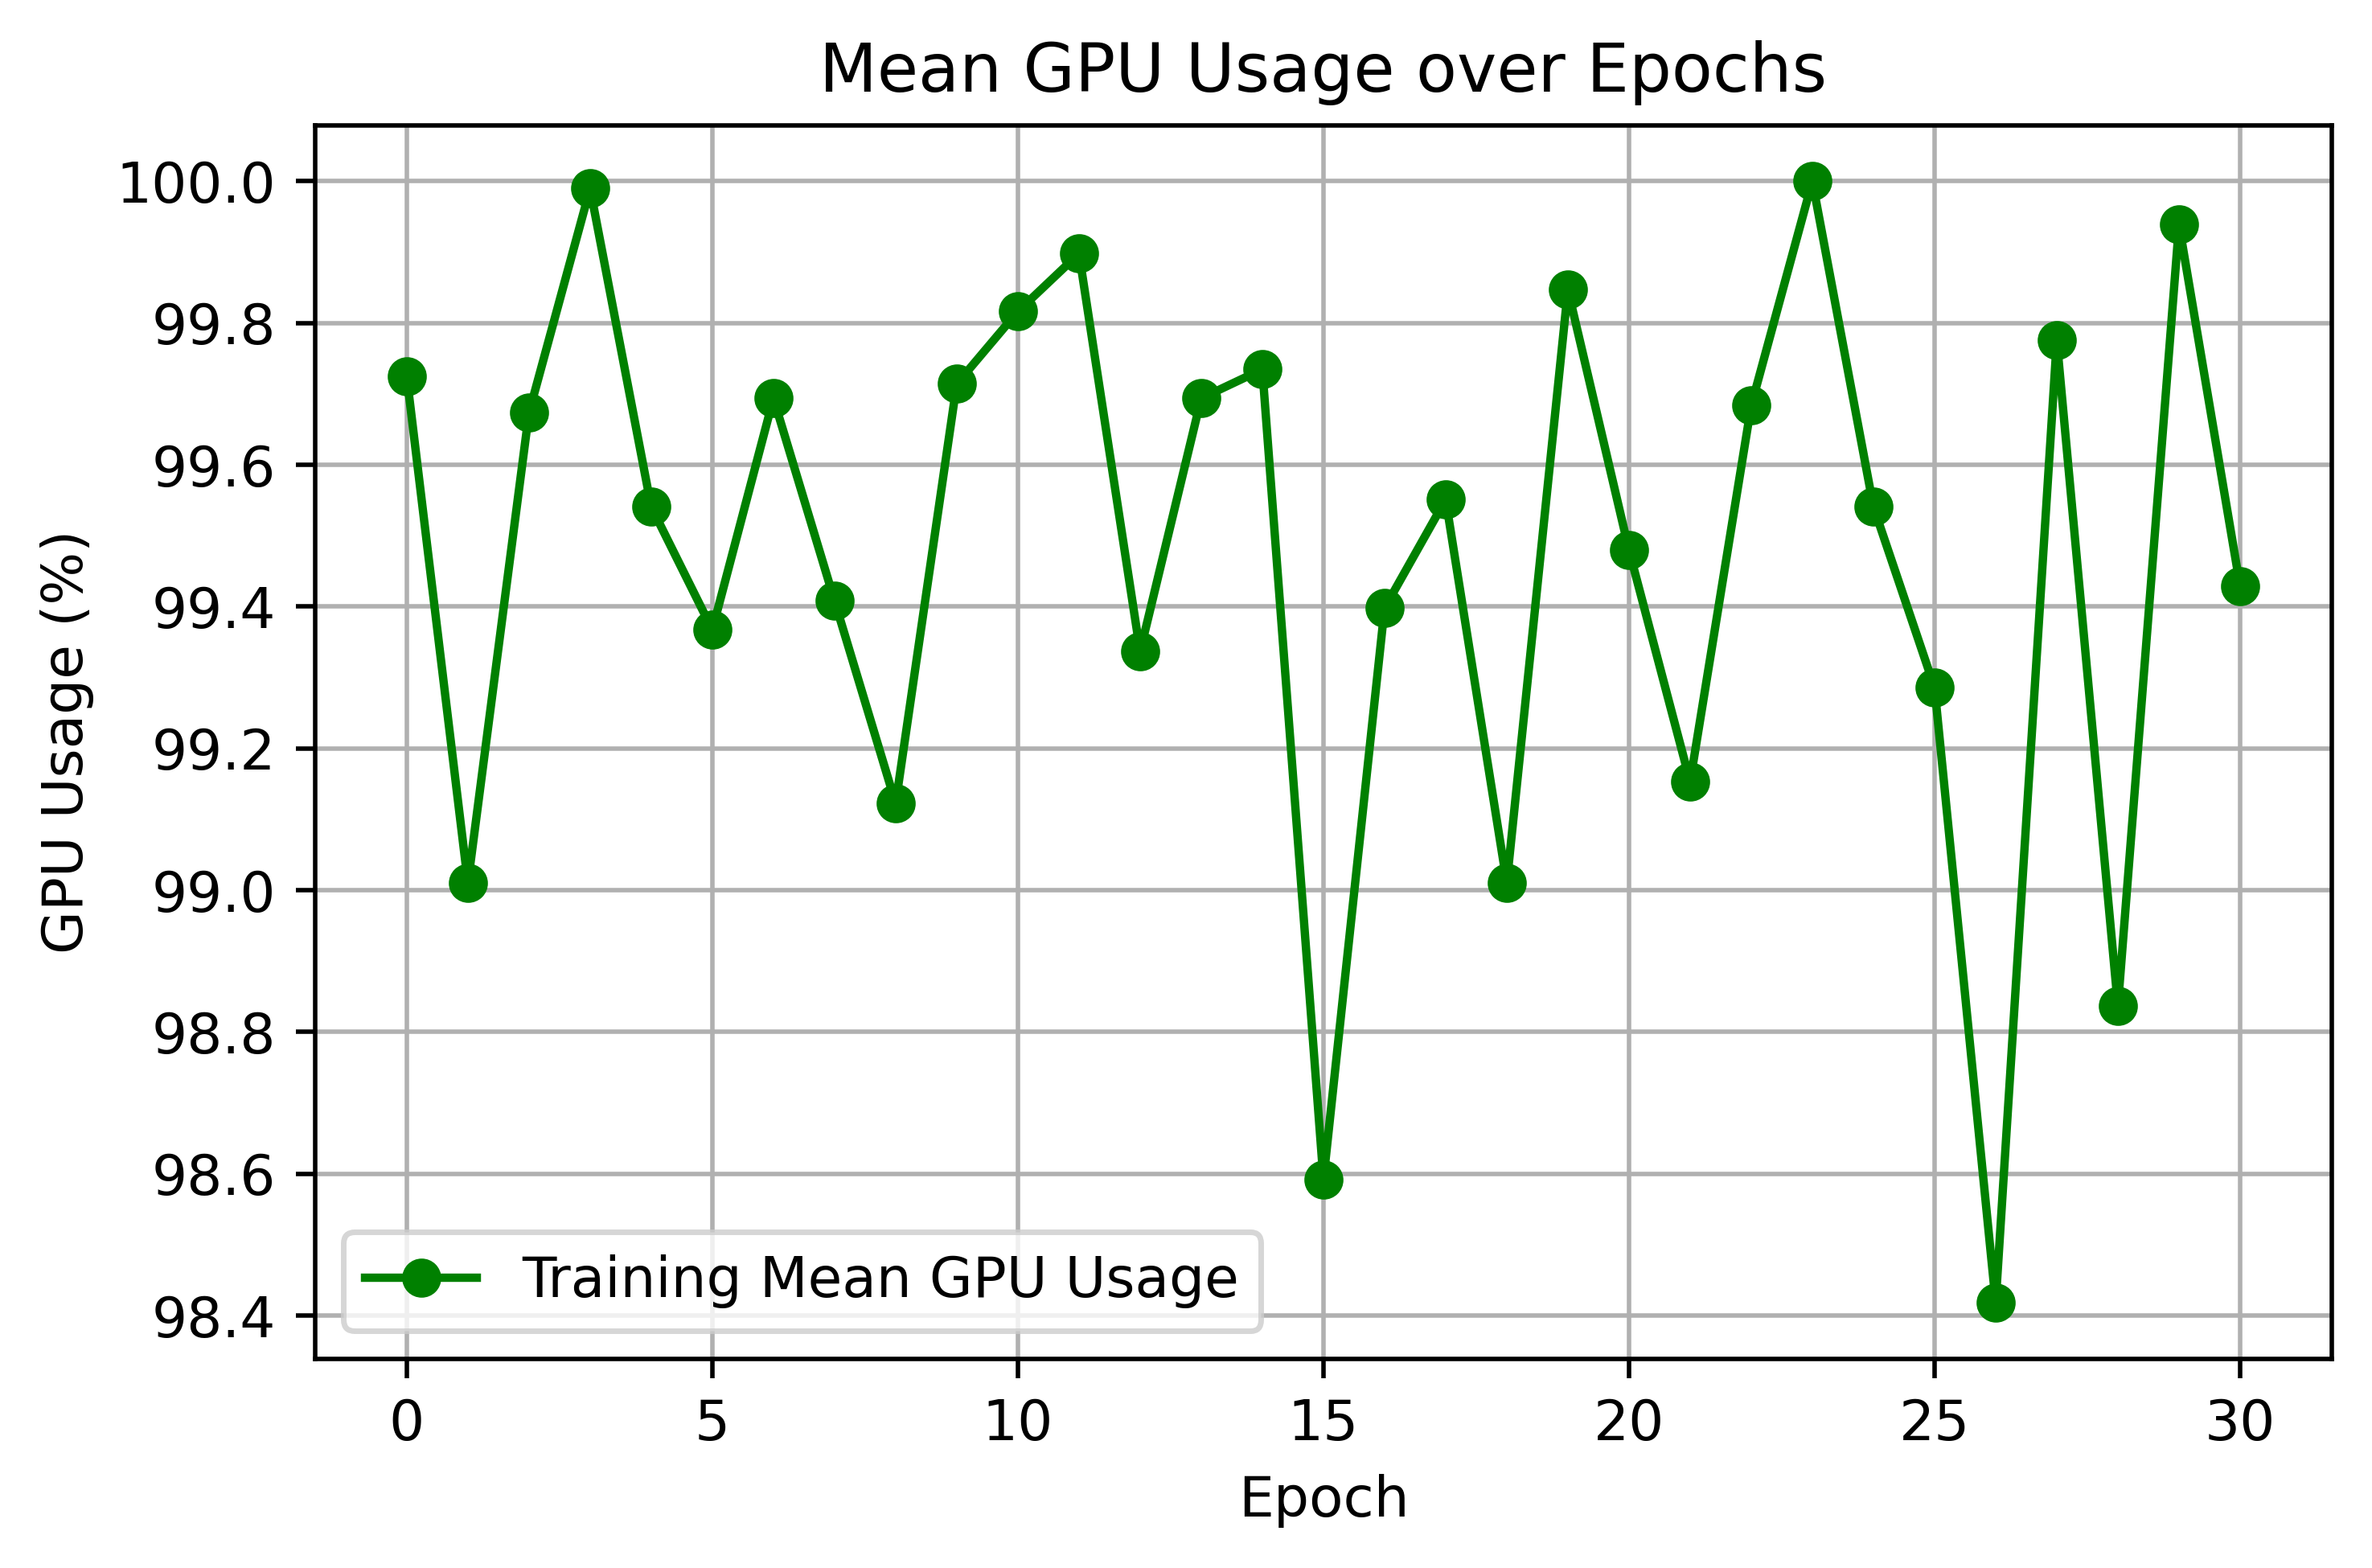

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


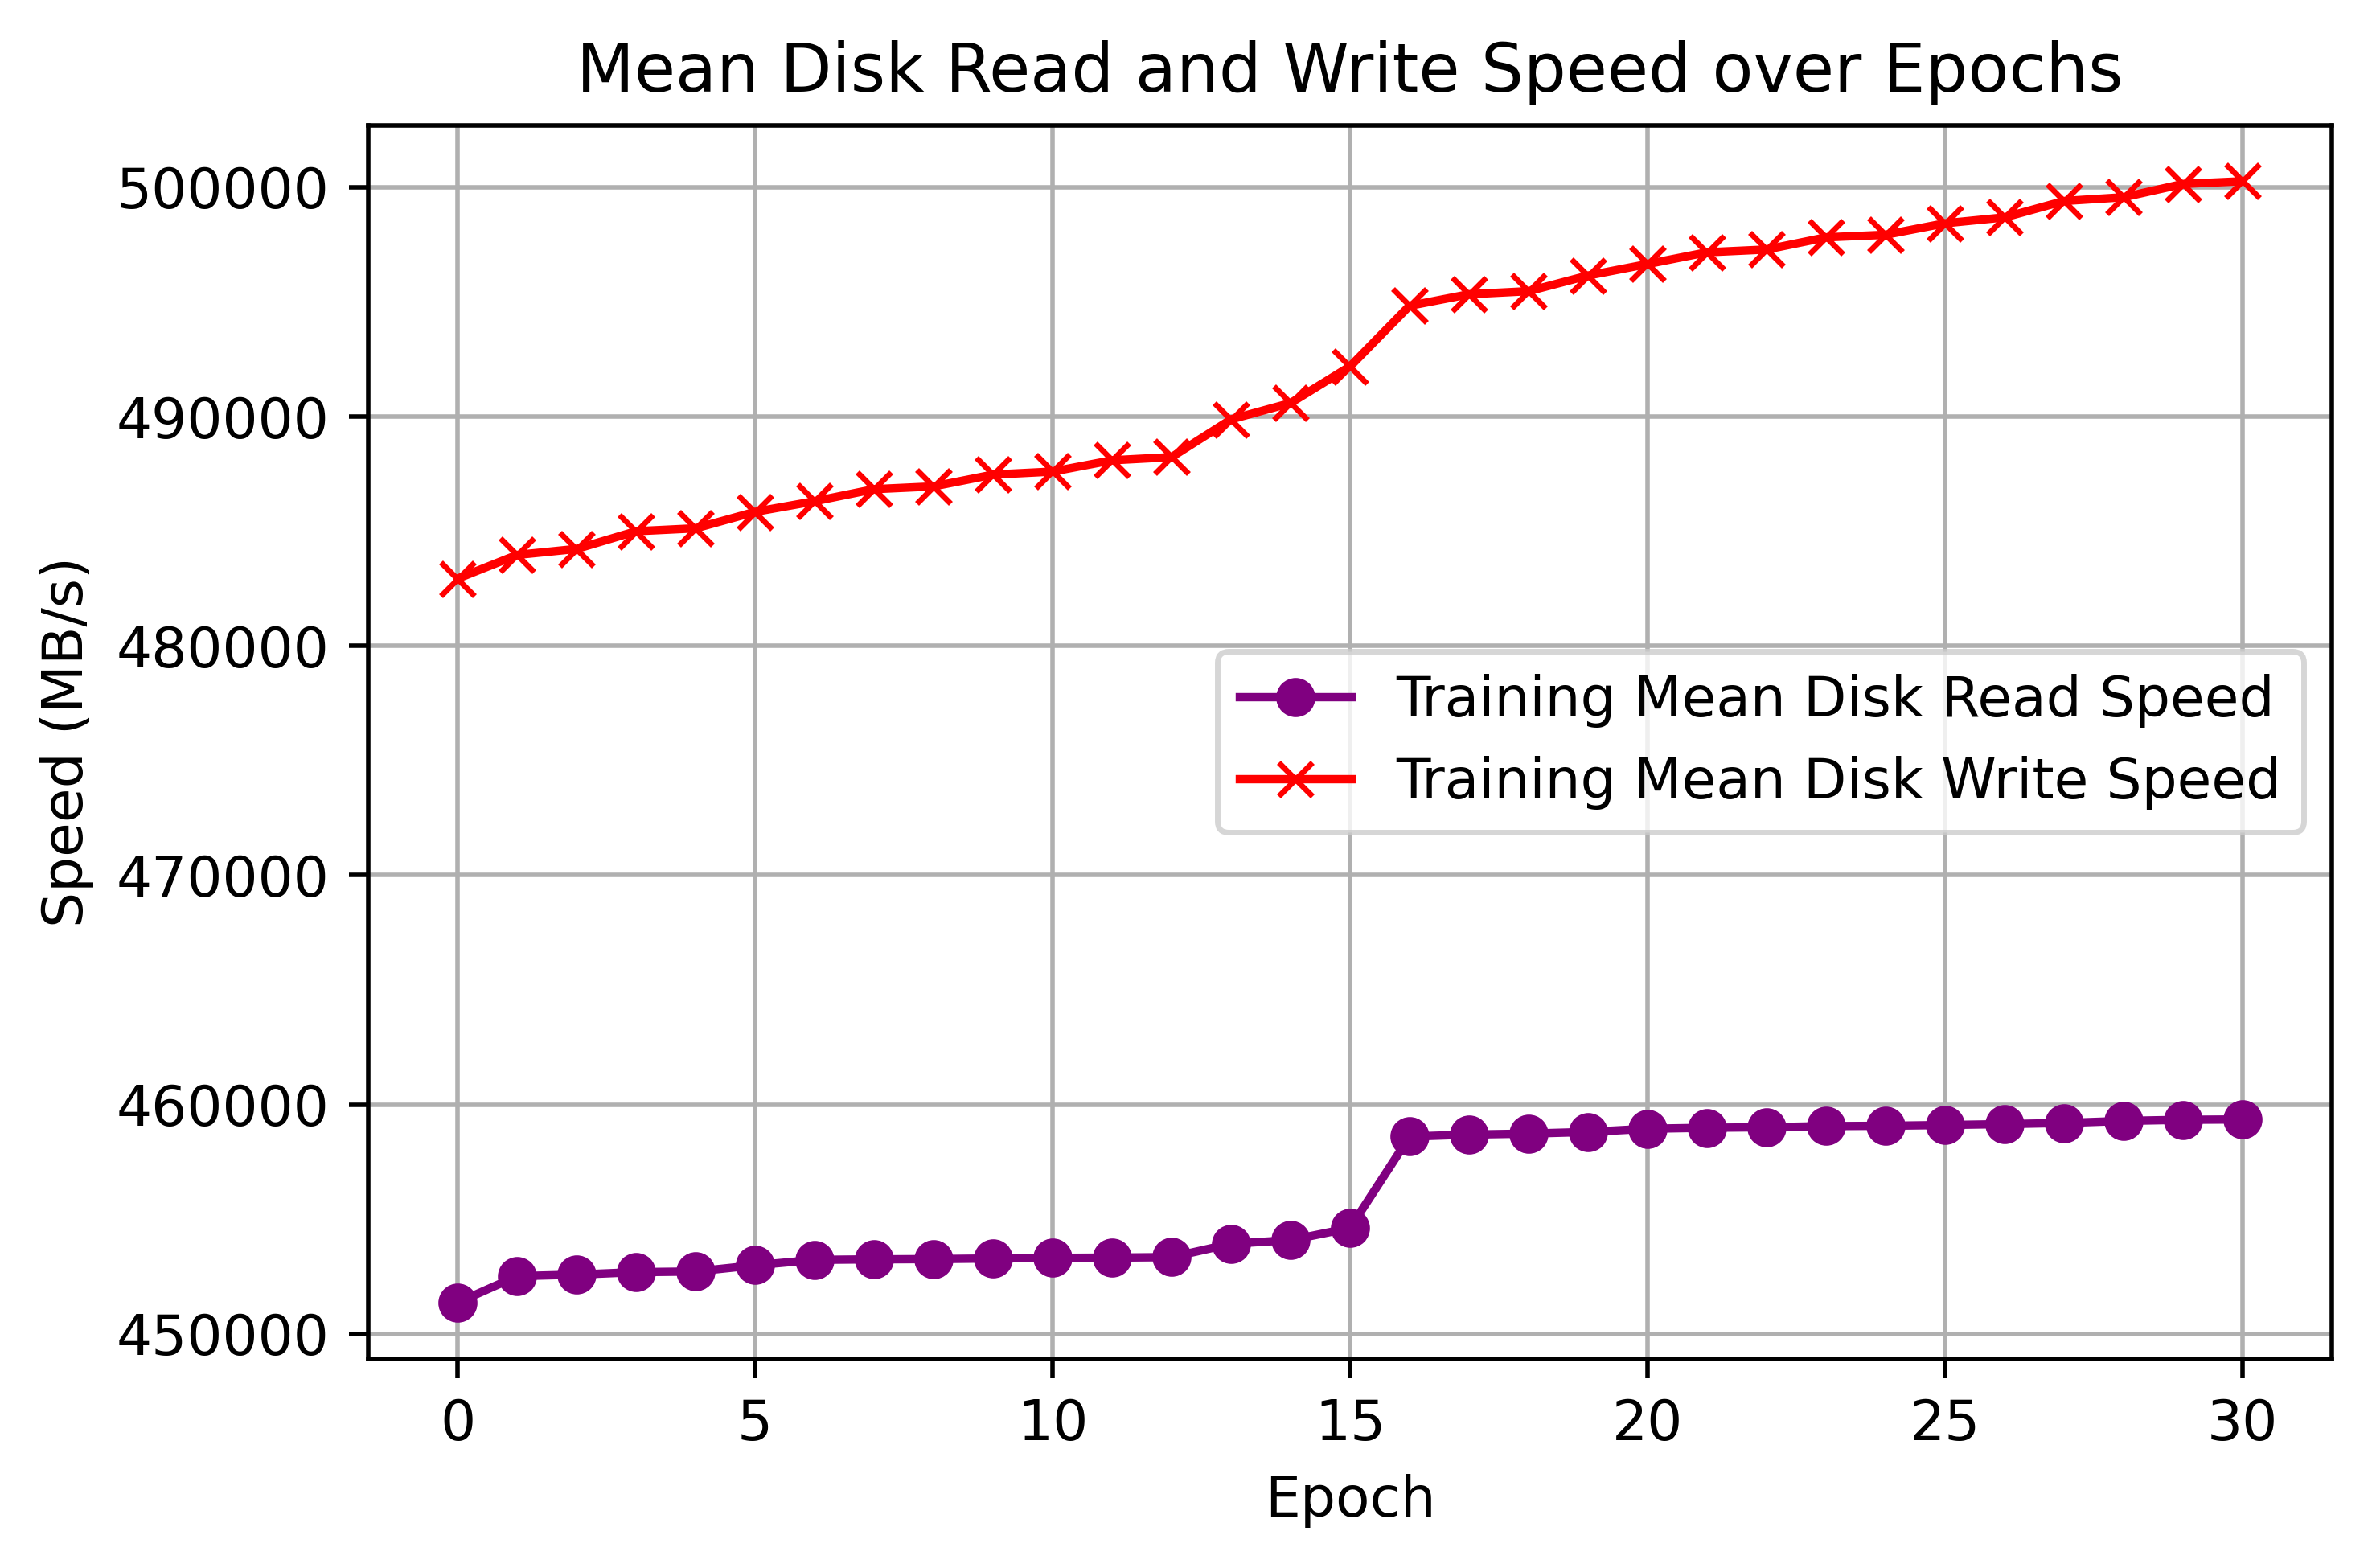

In [112]:
import matplotlib.pyplot as plt

# Plot Mean and Median Loss over Epochs
plt.figure(figsize=(6, 4), dpi=500)
plt.plot(df['Epoch'], df['Mean Loss'], marker='o', label=label_name+'Mean Loss', color='blue')
plt.plot(df['Epoch'], df['Median Loss'], marker='x', label=label_name+'Median Loss', color='orange')
plt.title('Mean and Median Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Save and show the plot
plt.tight_layout()
plt.savefig(graphs_save_folder+"Training_Mean_Median_Loss_Graph.png", dpi=500, bbox_inches='tight')
plt.savefig(graphs_save_folder+"Training_Mean_Median_Loss_Graph.eps", dpi=500, bbox_inches='tight')
plt.savefig(graphs_save_folder+"Training_Mean_Median_Loss_Graph.pdf", dpi=500, bbox_inches='tight')
plt.show()

# Plot Mean Accuracy over Epochs
plt.figure(figsize=(6, 4), dpi=500)
plt.plot(df['Epoch'], df['Mean Accuracy'], marker='o', label=label_name+'Mean Accuracy', color='green')
plt.title('Mean Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim(0, 1)  # Assuming accuracy is between 0 and 1
plt.legend()
plt.grid(True)

# Save and show the plot
plt.tight_layout()
plt.savefig(graphs_save_folder+"Training_Mean_Accuracy_Graph.png", dpi=500, bbox_inches='tight')
plt.savefig(graphs_save_folder+"Training_Mean_Accuracy_Graph.eps", dpi=500, bbox_inches='tight')
plt.savefig(graphs_save_folder+"Training_Mean_Accuracy_Graph.pdf", dpi=500, bbox_inches='tight')
plt.show()

# Plot Mean CPU Usage over Epochs
plt.figure(figsize=(6, 4), dpi=500)
plt.plot(df['Epoch'], df['Mean CPU Usage'], marker='o', label=label_name+'Mean CPU Usage', color='blue')
plt.title('Mean CPU Usage over Epochs')
plt.xlabel('Epoch')
plt.ylabel('CPU Usage (%)')
plt.legend()
plt.grid(True)

# Save and show the plot
plt.tight_layout()
plt.savefig(graphs_save_folder+"Training_Mean_CPU_Usage_Graph.png", dpi=500, bbox_inches='tight')
plt.savefig(graphs_save_folder+"Training_Mean_CPU_Usage_Graph.eps", dpi=500, bbox_inches='tight')
plt.savefig(graphs_save_folder+"Training_Mean_CPU_Usage_Graph.pdf", dpi=500, bbox_inches='tight')
plt.show()

# Plot Mean RAM Usage over Epochs
plt.figure(figsize=(6, 4), dpi=500)
plt.plot(df['Epoch'], df['Mean RAM Usage'], marker='o', label=label_name+'Mean RAM Usage', color='orange')
plt.title('Mean RAM Usage over Epochs')
plt.xlabel('Epoch')
plt.ylabel('RAM Usage (%)')
plt.legend()
plt.grid(True)

# Save and show the plot
plt.tight_layout()
plt.savefig(graphs_save_folder+"Training_Mean_RAM_Usage_Graph.png", dpi=500, bbox_inches='tight')
plt.savefig(graphs_save_folder+"Training_Mean_RAM_Usage_Graph.eps", dpi=500, bbox_inches='tight')
plt.savefig(graphs_save_folder+"Training_Mean_RAM_Usage_Graph.pdf", dpi=500, bbox_inches='tight')
plt.show()

# Plot Mean GPU Usage over Epochs
plt.figure(figsize=(6, 4), dpi=500)
plt.plot(df['Epoch'], df['Mean GPU Usage'], marker='o', label=label_name+'Mean GPU Usage', color='green')
plt.title('Mean GPU Usage over Epochs')
plt.xlabel('Epoch')
plt.ylabel('GPU Usage (%)')
plt.legend()
plt.grid(True)

# Save and show the plot
plt.tight_layout()
plt.savefig(graphs_save_folder+"Training_Mean_GPU_Usage_Graph.png", dpi=500, bbox_inches='tight')
plt.savefig(graphs_save_folder+"Training_Mean_GPU_Usage_Graph.eps", dpi=500, bbox_inches='tight')
plt.savefig(graphs_save_folder+"Training_Mean_GPU_Usage_Graph.pdf", dpi=500, bbox_inches='tight')
plt.show()

# Plot Mean Disk Read and Write Speed over Epochs
plt.figure(figsize=(6, 4), dpi=500)
plt.plot(df['Epoch'], df['Mean Disk Read Speed'], marker='o', label=label_name+'Mean Disk Read Speed', color='purple')
plt.plot(df['Epoch'], df['Mean Disk Write Speed'], marker='x', label=label_name+'Mean Disk Write Speed', color='red')
plt.title('Mean Disk Read and Write Speed over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Speed (MB/s)')
plt.legend()
plt.grid(True)

# Save and show the plot
plt.tight_layout()
plt.savefig(graphs_save_folder+"Training_Mean_Disk_Speed_Graph.png", dpi=500, bbox_inches='tight')
plt.savefig(graphs_save_folder+"Training_Mean_Disk_Speed_Graph.eps", dpi=500, bbox_inches='tight')
plt.savefig(graphs_save_folder+"Training_Mean_Disk_Speed_Graph.pdf", dpi=500, bbox_inches='tight')
plt.show()


In [113]:
import os
import json
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Directory containing the log files (update this path as needed)
log_dir = r'/home/sit-research/Desktop/Navneet Log Viz/train_log_data1'

# Initialize lists to store the data
epoch_numbers = []
mean_losses = []
median_losses = []
mean_accuracies = []

# Read all the custom_logs_epoch_train_*.json files
log_files = [f for f in os.listdir(log_dir) if f.startswith('custom_logs_epoch_train_') and f.endswith('.json')]

# Sort the log files based on the epoch number
log_files.sort(key=lambda x: int(x.split('_')[-1].split('.')[0]))

# Loop through each log file and extract mean and median losses, and accuracies
for log_file in log_files:
    epoch_number = int(log_file.split('_')[-1].split('.')[0])
    epoch_numbers.append(epoch_number)

    with open(os.path.join(log_dir, log_file), 'r') as file:
        data = json.load(file)
        
        losses = [step['train_loss'] for step in data['steps']]
        actions_preds = [step['actions_pred'] for step in data['steps']]  # Ensure this key exists in your logs
        actions = [step['actions'] for step in data['steps']]  # Ground truth actions
        
        # Calculate mean and median losses
        mean_loss = sum(losses) / len(losses)
        median_loss = pd.Series(losses).median()
        
        mean_losses.append(mean_loss)
        median_losses.append(median_loss)

        # Calculate accuracy
        accuracies = []
        for preds, true_actions in zip(actions_preds, actions):
            preds_array = np.array(preds)  # Shape: (1, 3, 20)
            true_actions_array = np.array(true_actions)  # Shape: (1, 20, 1)

            # Convert true actions to classes
            true_actions_classes = np.vectorize(convert_to_classes)(true_actions_array.flatten())  # Shape: (20,)

            # Get the index of the maximum predicted value
            preds_indices = preds_array.argmax(axis=1).flatten()  # Shape: (20,)

            # Calculate accuracy
            accuracy = (preds_indices == true_actions_classes).mean()
            accuracies.append(accuracy)

            # if accuracy != 0:
            #     print("accuracy", accuracy)

            # Calculate accuracy
            # print("preds_indices",preds_indices)
            # print("true_actions_classes",true_actions_classes)
            # print("preds_indices.shape",preds_indices.shape)
            # print("preds_array.shape",preds_array.shape)
            # print("true_actions_classes.shape",true_actions_classes.shape)

        mean_accuracy = np.mean(accuracies) if accuracies else None
        mean_accuracies.append(mean_accuracy)



# Create a DataFrame for easier plotting
df = pd.DataFrame({
    'Epoch': epoch_numbers,
    'Mean Loss': mean_losses,
    'Median Loss': median_losses,
    'Mean Accuracy': mean_accuracies
})

# Plotting
plt.figure(figsize=(14, 6))

# Plot Mean Loss
plt.subplot(1, 2, 1)
plt.plot(df['Epoch'], df['Mean Loss'], marker='o', label=label_name+'Mean Loss', color='blue')
plt.plot(df['Epoch'], df['Median Loss'], marker='x', label=label_name+'Median Loss', color='orange')
plt.title('Mean and Median Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid()

# Plot Mean Accuracy
plt.subplot(1, 2, 2)
plt.plot(df['Epoch'], df['Mean Accuracy'], marker='o', label=label_name+'Mean Accuracy', color='green')
plt.title('Mean Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
# plt.ylim(0, 1)  # Assuming accuracy is between 0 and 1
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()


FileNotFoundError: [WinError 3] The system cannot find the path specified: '/home/sit-research/Desktop/Navneet Log Viz/train_log_data1'

In [ ]:


# Plot mean average loss vs epoch number
plt.figure(figsize=(12, 6))
plt.plot(df['Epoch'], df['Mean Loss'], label=label_name+'Mean Loss', marker='o', color='blue')
plt.plot(df['Epoch'], df['Median Loss'], label=label_name+'Median Loss', marker='x', color='green')
plt.title('Mean and Median Loss vs Epoch Number')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(12, 6))


# Plot loss vs step for each epoch

for index in range(0, len(log_files), 10):
    log_file = log_files[index]
    # print(log_file)
    epoch_number = int(log_file.split('_')[-1].split('.')[0])
    
    with open(os.path.join(log_dir, log_file), 'r') as file:
        data = json.load(file)
        steps = [step['step'] for step in data['steps']]
        losses = [step['train_loss'] for step in data['steps']]    
    plt.plot(steps, losses, label=f'Epoch {epoch_number}', marker='o')
plt.title(f'Loss vs Step for Epoch {epoch_number}')
plt.xlabel('Step')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# # Plot loss vs step for each epoch
# for log_file in log_files:
#     epoch_number = int(log_file.split('_')[-1].split('.')[0])
    
#     with open(os.path.join(log_dir, log_file), 'r') as file:
#         data = json.load(file)
#         steps = [step['step'] for step in data['steps']]
#         losses = [step['train_loss'] for step in data['steps']]
    
#     plt.figure(figsize=(12, 6))
#     plt.plot(steps, losses, label=f'Epoch {epoch_number}', marker='o')
#     plt.title(f'Loss vs Step for Epoch {epoch_number}')
#     plt.xlabel('Step')
#     plt.ylabel('Loss')
#     plt.grid(True)
#     plt.show()


In [ ]:
import os
import json
import matplotlib.pyplot as plt

# Directory containing the log files (update this path as needed)
log_dir = r'/home/sit-research/Desktop/Navneet Log Viz/train_log_data1'

# Select epochs to plot
selected_epochs = [1, 10, 20, 30, 40]
metrics = {
    'steps': [],
    'accuracies': {}
}

# Read all the custom_logs_epoch_train_*.json files
log_files = [f for f in os.listdir(log_dir) if f.startswith('custom_logs_epoch_train_') and f.endswith('.json')]
log_files.sort(key=lambda x: int(x.split('_')[-1].split('.')[0]))

# Loop through each log file to extract accuracy data for selected epochs
for log_file in log_files:
    epoch_number = int(log_file.split('_')[-1].split('.')[0])
    
    if epoch_number in selected_epochs:
        with open(os.path.join(log_dir, log_file), 'r') as file:
            data = json.load(file)
            steps = [step['step'] for step in data['steps']]
            actions_preds = [step['actions_pred'] for step in data['steps']]
            actions = [step['actions'] for step in data['steps']]
            
            # Store steps for plotting (assuming they are consistent across selected epochs)
            if not metrics['steps']:
                metrics['steps'] = steps
            
            # Calculate accuracy for each step
            accuracies = []
            for preds, true_actions in zip(actions_preds, actions):
                preds_array = np.array(preds)
                true_actions_array = np.array(true_actions).flatten()
                
                # Convert true actions to classes
                true_actions_classes = np.vectorize(convert_to_classes)(true_actions_array)
                preds_indices = preds_array.argmax(axis=1).flatten()
                
                # Calculate accuracy
                accuracy = (preds_indices == true_actions_classes).mean()
                accuracies.append(accuracy)
            
            # Store accuracies for the current epoch
            metrics['accuracies'][epoch_number] = accuracies

# Plotting
plt.figure(figsize=(14, 8))

# Plot Accuracy vs Step for each selected epoch
for epoch in selected_epochs:
    if epoch in metrics['accuracies']:
        plt.plot(metrics['steps'], metrics['accuracies'][epoch], marker='o', label=f'Epoch {epoch}')

plt.title('Accuracy vs Step for Selected Epochs')
plt.xlabel('Step')
plt.ylabel('Accuracy')
plt.ylim(0, 1)  # Assuming accuracy is between 0 and 1
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()


In [ ]:
import os
import json
import matplotlib.pyplot as plt
import numpy as np
# Directory containing the log files (update this path as needed)
log_dir = r'/home/sit-research/Desktop/Navneet Log Viz/train_log_data1'

# Read all the custom_logs_epoch_train_*.json files
log_files = [f for f in os.listdir(log_dir) if f.startswith('custom_logs_epoch_train_') and f.endswith('.json')]
log_files.sort(key=lambda x: int(x.split('_')[-1].split('.')[0]))

# Initialize lists for storing metrics
selected_epochs = [1, 10, 20, 30, 40, 50, 60, 70]  # Add more as needed
selected_epochs = [1, 10, 20, 30, 40, 50, 60, 70]  # Add more as needed
metrics = {
    'steps': [],
    'cpu_usages': {},
    'ram_usages': {},
    'gpu_usages': {},
    'vram_usages': {},
    'disk_read_speeds': {},
    'disk_write_speeds': {}
}

# Loop through the log files to extract metrics for selected epochs
for log_file in log_files:
    epoch_number = int(log_file.split('_')[-1].split('.')[0])
    
    if epoch_number in selected_epochs:
        with open(os.path.join(log_dir, log_file), 'r') as file:
            data = json.load(file)
            steps = [step['step'] for step in data['steps']]
            cpu_usages = [step['CPU Usage'] for step in data['steps']]
            ram_usages = [step['RAM Usage'] for step in data['steps']]
            gpu_usages = [step['GPU Usage'] for step in data['steps']]
            vram_usages = [step['VRAM Usage'] for step in data['steps']]
            disk_read_speeds = [step['Disk Read Speed (MB/s)'] for step in data['steps']]
            disk_write_speeds = [step['Disk Write Speed (MB/s)'] for step in data['steps']]

            # Store metrics by epoch number
            metrics['steps'] = steps  # Assuming steps are the same for each selected epoch
            metrics['cpu_usages'][epoch_number] = cpu_usages
            metrics['ram_usages'][epoch_number] = ram_usages
            metrics['gpu_usages'][epoch_number] = gpu_usages
            metrics['vram_usages'][epoch_number] = vram_usages
            metrics['disk_read_speeds'][epoch_number] = disk_read_speeds
            metrics['disk_write_speeds'][epoch_number] = disk_write_speeds
            print("epoch",epoch_number)
            print("mean GPU Usage:",np.mean(gpu_usages))

# Plotting
plt.figure(figsize=(14, 10))

# Plot CPU Usage
plt.subplot(3, 2, 1)
for epoch in selected_epochs:
    plt.plot(metrics['steps'], metrics['cpu_usages'][epoch], label=f'Epoch {epoch}', marker='o')
plt.title('CPU Usage vs Step')
plt.xlabel('Step')
plt.ylabel('CPU Usage (%)')
plt.legend()
plt.grid()

# Plot RAM Usage
plt.subplot(3, 2, 2)
for epoch in selected_epochs:
    plt.plot(metrics['steps'], metrics['ram_usages'][epoch], label=f'Epoch {epoch}', marker='o')
plt.title('RAM Usage vs Step')
plt.xlabel('Step')
plt.ylabel('RAM Usage (%)')
plt.legend()
plt.grid()

# Plot GPU Usage
plt.subplot(3, 2, 3)
for epoch in selected_epochs:
    plt.plot(metrics['steps'], metrics['gpu_usages'][epoch], label=f'Epoch {epoch}', marker='o')
plt.title('GPU Usage vs Step')
plt.xlabel('Step')
plt.ylabel('GPU Usage (%)')
plt.legend()
plt.grid()

# Plot VRAM Usage
plt.subplot(3, 2, 4)
for epoch in selected_epochs:
    plt.plot(metrics['steps'], metrics['vram_usages'][epoch], label=f'Epoch {epoch}', marker='o')
plt.title('VRAM Usage vs Step')
plt.xlabel('Step')
plt.ylabel('VRAM Usage (%)')
plt.legend()
plt.grid()

# Plot Disk Read Speed
plt.subplot(3, 2, 5)
for epoch in selected_epochs:
    plt.plot(metrics['steps'], metrics['disk_read_speeds'][epoch], label=f'Epoch {epoch}', marker='o')
plt.title('Disk Read Speed vs Step')
plt.xlabel('Step')
plt.ylabel('Read Speed (MB/s)')
plt.legend()
plt.grid()

# Plot Disk Write Speed
plt.subplot(3, 2, 6)
for epoch in selected_epochs:
    plt.plot(metrics['steps'], metrics['disk_write_speeds'][epoch], label=f'Epoch {epoch}', marker='o')
plt.title('Disk Write Speed vs Step')
plt.xlabel('Step')
plt.ylabel('Write Speed (MB/s)')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()


### Plot Returns for each epoch

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming you've already imported required libraries and set up your data as before

# Read and extract returns for each epoch
epoch_returns = {}

# Loop through each log file and extract returns along with the epoch
for log_file in log_files:
    epoch_number = int(log_file.split('_')[-1].split('.')[0])
    
    with open(os.path.join(log_dir, log_file), 'r') as file:
        data = json.load(file)
        
        returns = np.array([step['returns'] for step in data['steps']])
        # Reshape returns if necessary
        returns = returns.flatten()

        # print(np.mean(returns))
        
        # Store returns for the current epoch
        epoch_returns[epoch_number] = returns

# Plot returns vs steps for each epoch in separate graphs
for epoch_number, returns in epoch_returns.items():
    plt.figure(figsize=(10, 5))
    steps = np.arange(len(returns))  # Create an array for step numbers
    plt.plot(steps, returns, marker='o', label=f'Epoch {epoch_number}')
    
    plt.title(f'Returns vs Steps for Epoch {epoch_number}')
    plt.xlabel('Step Number')
    plt.ylabel('Returns')
    plt.grid(True)
    plt.legend()
    
    # Show each plot
    plt.show()

# Set the figure size
plt.figure(figsize=(12, 6))

# Plot Mean Return
plt.subplot(1, 2, 1)
plt.plot(df['Epoch'], df['Mean Return'], marker='o', color='blue', label=label_name+'Mean Return')
plt.title('Mean Return vs Epoch Number')
plt.xlabel('Epoch Number')
plt.ylabel('Mean Return')
plt.grid(True)
plt.legend()

# Plot Median Return
plt.subplot(1, 2, 2)
plt.plot(df['Epoch'], df['Median Return'], marker='o', color='orange', label=label_name+'Median Return')
plt.title('Median Return vs Epoch Number')
plt.xlabel('Epoch Number')
plt.ylabel('Median Return')
plt.grid(True)
plt.legend()

# Show the plots
plt.tight_layout()
plt.show()
